**Pull in one grid cell from a CMIP6 model and run through rolling cdf test**

In [1]:
import intake
import xarray as xr
import os 
import pandas as pd
import numpy as np
import zarr 
import rhg_compute_tools.kubernetes as rhgk

from xclim.core.calendar import convert_calendar

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
write_direc = '../figures/'

In [4]:
client, cluster = rhgk.get_big_cluster()
cluster.scale(30)

In [5]:
client

<Client: 'tls://10.20.55.2:8786' processes=0 threads=0, memory=0 B>

In [158]:
cluster.close()

get some CMIP6 data from GCS. 

here we're going to get daily `tmax` from `IPSL` for historical and SSP370 runs. The ensemble member `r1i1p1f1` isn't available in GCS so we're using `r4i1p1f1` instead. 

Note that the `activity_id` for historical runs is `CMIP`, not `ScenarioMIP` as it is for the ssp-rcp scenarios. 

In [6]:
activity_id = 'ScenarioMIP'
experiment_id = 'ssp370'
table_id = 'day'
variable_id = 'tasmax'
source_id = 'ACCESS-ESM1-5' # 'IPSL-CM6A-LR'
institution_id = 'NCAR'
member_id = 'r1i1p1f1'

look at options first

In [7]:
df_cmip6 = pd.read_csv('https://cmip6.storage.googleapis.com/cmip6-zarr-consolidated-stores-noQC.csv', dtype={'version': 'unicode'})
len(df_cmip6)

495803

In [8]:
df_subset_future = df_cmip6.loc[(df_cmip6['activity_id'] == activity_id) & (df_cmip6['experiment_id'] == experiment_id) 
             & (df_cmip6['table_id'] == table_id) & (df_cmip6['variable_id'] == variable_id)
             & (df_cmip6['source_id'] == source_id) & (df_cmip6['member_id'] == member_id)]

In [9]:
df_subset_future

activity_id institution_id      source_id experiment_id member_id  \
374784  ScenarioMIP          CSIRO  ACCESS-ESM1-5        ssp370  r1i1p1f1   

       table_id variable_id grid_label  \
374784      day      tasmax         gn   

                                                   zstore  dcpp_init_year  \
374784  gs://cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1...             NaN   

         version status severity issue_url  
374784  20191115   good     none      none

In [10]:
df_subset_hist = df_cmip6.loc[(df_cmip6['experiment_id'] == 'historical') 
             & (df_cmip6['table_id'] == table_id) & (df_cmip6['variable_id'] == variable_id) 
             & (df_cmip6['source_id'] == source_id) & (df_cmip6['member_id'] == member_id)]

In [11]:
df_subset_hist

activity_id institution_id      source_id experiment_id member_id  \
374143        CMIP          CSIRO  ACCESS-ESM1-5    historical  r1i1p1f1   

       table_id variable_id grid_label  \
374143      day      tasmax         gn   

                                                   zstore  dcpp_init_year  \
374143  gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/hist...             NaN   

         version status severity issue_url  
374143  20191115   good     none      none

Now actually pull the data

In [12]:
# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

cat = col.search(activity_id=['CMIP', activity_id], 
                 experiment_id=['historical', experiment_id], table_id=table_id, variable_id=variable_id,
                 source_id=source_id, member_id=member_id)

In [13]:
cat

In [14]:
cat['CMIP.CSIRO.ACCESS-ESM1-5.historical.day.gn']

In [15]:
ds_model = {}
ds_model['historical'] = cat['CMIP.CSIRO.ACCESS-ESM1-5.historical.day.gn'].to_dask().isel(member_id=0
                                                                                       ).squeeze(drop=True).drop(['member_id',
                                                                                                                  'height'])

Define the historical and simulated datasets

In [16]:
hist_ds = ds_model['historical']
hist_ds

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 60265)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(582, 145, 192), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   21915.0
    cmor_version:            3.4.0
    creation_date:           2019-11-15T17:28:16Z
    data_specs_version:      01.00.30
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacella
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCES...
    grid:                    native atmosphere N96 grid (145x192 latxlon)
    grid_label:              gn
    history:                 2019-11-15T17:28:16Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             Commonwealth Scientific and Industrial Research ...
    institution_id:          CSIRO
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    mip_era:                 CMIP6
    nominal_resolution:      250 km
    notes:                   Exp: ESM-historical; Local ID: HI-05; Variable: ...
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        ACCESS-ESM1-5
    parent_time_units:       days since 0101-1-1
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    source:                  ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\...
    source_id:               ACCESS-ESM1-5
    source_type:             AOGCM
    status:                  2020-06-24;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                day
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    title:                   ACCESS-ESM1-5 output prepared for CMIP6
    tracking_id:             hdl:21.14100/67543e90-bb83-44b1-8a30-e1fbb5ada0d...
    variable_id:             tasmax
    variant_label:           r1i1p1f1
    version:                 v20191115
    intake_esm_varname:      ['tasmax']
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.day.gn

In [17]:
ds_model['ssp370'] = cat['ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp370.day.gn'].to_dask().isel(member_id=0
                                                                                       ).squeeze(drop=True).drop(['member_id',
                                                                                                                  'height'])

In [18]:
sim_ds = ds_model['ssp370']
sim_ds

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 31411)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(583, 145, 192), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP AerChemMIP
    branch_method:           standard
    branch_time_in_child:    60265.0
    branch_time_in_parent:   60265.0
    cmor_version:            3.4.0
    creation_date:           2019-11-15T10:38:50Z
    data_specs_version:      01.00.30
    experiment:              gap-filling scenario reaching 7.0 based on SSP3
    experiment_id:           ssp370
    external_variables:      areacella
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCES...
    grid:                    native atmosphere N96 grid (145x192 latxlon)
    grid_label:              gn
    history:                 2019-11-15T10:38:50Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             Commonwealth Scientific and Industrial Research ...
    institution_id:          CSIRO
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    mip_era:                 CMIP6
    nominal_resolution:      250 km
    notes:                   Exp: ESM-ssp370; Local ID: SSP-370-05; Variable:...
    parent_activity_id:      CMIP
    parent_experiment_id:    historical
    parent_mip_era:          CMIP6
    parent_source_id:        ACCESS-ESM1-5
    parent_time_units:       days since 1850-1-1
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    source:                  ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\...
    source_id:               ACCESS-ESM1-5
    source_type:             AOGCM
    status:                  2020-06-24;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                day
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    title:                   ACCESS-ESM1-5 output prepared for CMIP6
    tracking_id:             hdl:21.14100/701b06d0-3da1-47c4-a2ed-4635778cb16...
    variable_id:             tasmax
    variant_label:           r1i1p1f1
    version:                 v20191115
    intake_esm_varname:      ['tasmax']
    intake_esm_dataset_key:  ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp370.day.gn

Pull in tasmax from ERA-5 for the reference dataset from 1995-2014

In [19]:
# Per decade analysis
filenames = []

yrs = np.arange(1995,2015) 
    
for num_yrs in range(len(yrs)):
    filename = '/gcs/impactlab-data/climate/source_data/ERA-5/day/tmax/v1.1/tmax_daily_{}-{}.nc'.format(yrs[num_yrs], yrs[num_yrs])
    filenames.append(filename)
    
era5_tmax = xr.open_mfdataset(filenames, concat_dim='time', combine='by_coords')
print('Loading ERA5 files...')
print(era5_tmax['tmax'])

Loading ERA5 files...
<xarray.DataArray 'tmax' (time: 7305, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(7305, 721, 1440), dtype=float32, chunksize=(366, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2014-12-31


In [20]:
ref_ds = era5_tmax
ref_ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 7305)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2014-12-31
Data variables:
    tmax       (time, latitude, longitude) float32 dask.array<chunksize=(365, 721, 1440), meta=np.ndarray>
Attributes:
    author:   Meredith Fish
    contact:  meredith.fish@rutgers.edu
    project:  impactlab-rhg/climate/source-data/ERA-5
    source:   impactlab-rhg/climate/downscaled/ERA-5/hourly
    created:  2021-02-16

In [21]:
# Select a single grid point for analysis -- Denver, CO, Miami, FL
# Miami, FL
#lat = 25.78
#lon = 280.0 

# Denver, CO
lat = 40.0 
lon = 260.0 

# Houston, TX
#lat = 29.75
#lon = 265.0

# Lagos, Nigeria
#lat = 6.52
#lon = 3.35

# Mumbai, India
#lat = 19.08
#lon = 72.86

ref_da = ref_ds['tmax'].sel(latitude=lat, longitude=lon, method='nearest')
hist_da = hist_ds['tasmax'].sel(lat=lat, lon=lon, method='nearest')
sim_da = sim_ds['tasmax'].sel(lat=lat, lon=lon, method='nearest')

In [22]:
hist_da = hist_da.sel(time=slice('1995-01-01','2014-12-31'))
hist_da

<xarray.DataArray 'tasmax' (time: 7305)>
dask.array<getitem, shape=(7305,), dtype=float32, chunksize=(582,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 40.0
    lon      float64 260.6
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-11-15T17:28:16Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

In [ ]:
hist_da

In [23]:
# remove leap days and convert calendar to no-leap
ref = convert_calendar(ref_da, 'noleap')
hist = convert_calendar(hist_da, 'noleap')
sim = convert_calendar(sim_da, 'noleap')

In [53]:
# still want to assign dayofyear coordinate

def assign_dayofyear_coord(da):
    
    years = np.arange(da.time.dt.year.min(),da.time.dt.year.max()+1)
    da_wcoords = da.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(years)).flatten(),
                                                dims=('time'),
                                                coords={'time':da.time})).persist()
    return da_wcoords

In [55]:
ref = assign_dayofyear_coord(ref)
hist = assign_dayofyear_coord(hist)
sim = assign_dayofyear_coord(sim)

In [56]:
sim

<xarray.DataArray 'tasmax' (time: 31390)>
array([269.31406, 274.50302, 274.6317 , ..., 285.3978 , 283.96222,
       286.47925], dtype=float32)
Coordinates:
    lat        float64 40.0
    lon        float64 260.6
  * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-11-15T10:38:50Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

In [57]:
ref = ref.load()
hist = hist.load()
sim = sim.load()

Load necessary packages, etc. for QDM implementation

In [25]:
! pip install git+https://github.com/ClimateImpactLab/xclim.git@qdm_add_year_selection

  Cloning https://github.com/ClimateImpactLab/xclim.git (to revision qdm_add_year_selection) to /tmp/pip-req-build-fo91rwls


In [26]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import dask
import dask.array as da
import dask.distributed as dd
import xclim
from xclim import sdba
from scipy.stats import scoreatpercentile
from scipy.stats.kde import gaussian_kde

from xclim.testing.tests.test_sdba import utils as tu

In [27]:
write_direc = '../figures/'

In [119]:
nquantiles = 400 #620 is empirical
kind = "+" #"*" #"+"

if kind=='*':
    kindstr='mult'
else:
    kindstr='add'

In [142]:
grouper = "time" # .dayofyear"
window = 1 

grouper = sdba.Grouper(grouper, window=window)

QMdg = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QMdg.train(ref, hist) #(ref, hist)  

DQMdg = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
DQMdg.train(ref, hist)

QDMdg = sdba.adjustment.QuantileDeltaMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QDMdg.train(ref, hist)

In [121]:
n400_denver = QDMdg.ds.af
n400_denver

<xarray.DataArray 'af' (dayofyear: 365, quantiles: 402)>
array([[-4.3487643 , -4.05559784, -3.05136581, ...,  4.20553238,
         3.482005  ,  1.05388497],
       [-4.34876391, -4.05511208, -3.05246754, ...,  4.20501842,
         3.48602829,  1.05388819],
       [-4.34876353, -4.05462631, -3.05356926, ...,  4.20450447,
         3.49005157,  1.05389141],
       ...,
       [-2.65747858, -2.17180801, -3.01785187, ...,  4.13545639,
         3.49005157,  1.05389141],
       [-3.75025904, -3.08277416, -3.1536232 , ...,  4.13692055,
         3.48602829,  1.05388819],
       [-3.74974577, -2.44117905, -3.05136581, ...,  4.20553238,
         3.482005  ,  1.05388497]])
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.00125 0.00375 ... 0.9962 0.9988 1.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    group:               time.dayofyear
    group_compute_dims:  ['time', 'window']
    group_window:        31
    kind:                +
    standard_name:       Adjustment factors
    long_name:           Quantile mapping adjustment factors

In [118]:
n100_denver = QDMdg.ds.af
n100_denver

<xarray.DataArray 'af' (dayofyear: 365, quantiles: 102)>
array([[-4.3487643 , -3.27698792, -4.73591187, ...,  4.23525635,
         4.12087341,  1.05388497],
       [-4.34876391, -3.27940903, -4.73527374, ...,  4.1675087 ,
         4.10283127,  1.05388819],
       [-4.34876353, -3.28183014, -4.74083466, ...,  4.16765472,
         4.10243805,  1.05389141],
       ...,
       [-2.65747858, -3.14864227, -4.68978668, ...,  4.16160614,
         3.88200043,  1.05389141],
       [-3.75025904, -3.40869293, -5.03976898, ...,  4.32049255,
         3.87690201,  1.05388819],
       [-3.74974577, -3.27698792, -4.73591187, ...,  4.3905658 ,
         4.12087341,  1.05388497]])
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.005 0.015 0.025 ... 0.985 0.995 1.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    group:               time.dayofyear
    group_compute_dims:  ['time', 'window']
    group_window:        31
    kind:                +
    standard_name:       Adjustment factors
    long_name:           Quantile mapping adjustment factors

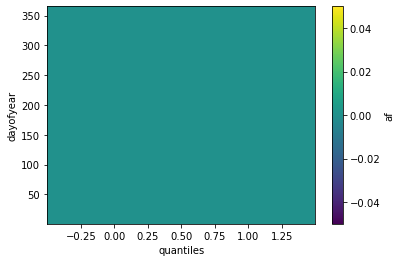

In [116]:
(n400_denver - n100_denver).plot()

In [126]:
QDMdg.ds.quantiles

<xarray.DataArray 'quantiles' (quantiles: 402)>
array([1.00000e-06, 1.25000e-03, 3.75000e-03, ..., 9.96250e-01, 9.98750e-01,
       9.99999e-01])
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.00125 0.00375 ... 0.9962 0.9988 1.0

In [143]:
hist_qdm = QDMdg.adjust(hist)
sim_qdm = QDMdg.adjust(sim)

In [144]:
hist_qdm

<xarray.DataArray (time: 7300)>
array([274.48236008, 280.09579742, 276.53138336, ..., 277.26005795,
       278.80806309, 274.9746664 ])
Coordinates:
    lat        float64 40.0
    lon        float64 260.6
  * time       (time) object 1995-01-01 12:00:00 ... 2014-12-31 12:00:00
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-11-15T17:28:16Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    xclim_history:  2019-11-15T17:28:16Z altered by CMOR: Treated scalar dime...

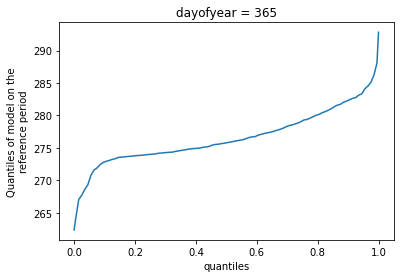

In [38]:
QDMdg.ds.hist_q.sel(dayofyear=365).plot()

Text(0.5, 1.0, 'Reference and Historical GCM quantiles')

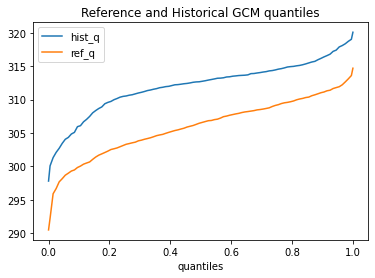

In [40]:
# Plot of the quantiled time series for GCM Hist (hist_q) and Obs Ref (ref_q) - these are basically cdfs

QDMdg.ds.hist_q.sel(dayofyear=210).plot()
(QDMdg.ds.af.sel(dayofyear=210) + QDMdg.ds.hist_q.sel(dayofyear=210)).plot()
plt.legend(('hist_q','ref_q'))
plt.title('Reference and Historical GCM quantiles')

Text(0.5, 1.0, 'Reference and Historical GCM quantiles')

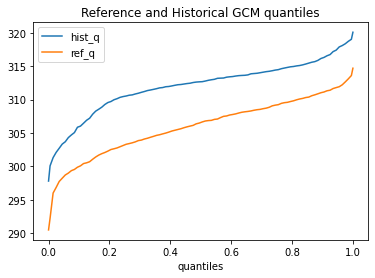

In [67]:
# Plot of the quantiled time series for GCM Fut (fut_q) and QDM sim (sim_qdm) - these are basically cdfs

QDMdg.ds.hist_q.sel(dayofyear=210).plot()
(QDMdg.ds.af.sel(dayofyear=210) + QDMdg.ds.hist_q.sel(dayofyear=210)).plot()
plt.legend(('hist_q','ref_q'))
plt.title('Reference and Historical GCM quantiles')

In [101]:
hist_qdm = QDMdg.adjust(hist, interp='nearest')
sim_qdm = QDMdg.adjust(sim, interp='nearest')

hist_qdm_lin = QDMdg.adjust(hist, interp='linear')
sim_qdm_lin = QDMdg.adjust(sim, interp='linear')

hist_qdm_cub = QDMdg.adjust(hist, interp='cubic')
sim_qdm_cub = QDMdg.adjust(sim, interp='cubic')

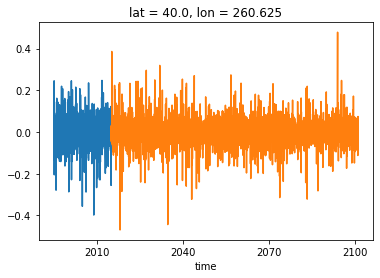

In [102]:
(hist_qdm_lin - hist_qdm).plot()
(sim_qdm_lin - sim_qdm).plot()

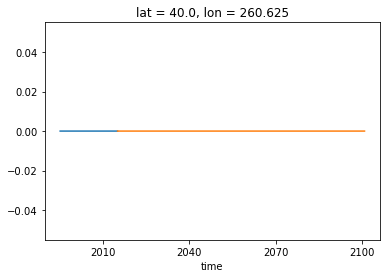

In [60]:
(hist_qdm_lin - hist_qdm_cub).plot()
(sim_qdm_lin - sim_qdm_cub).plot()

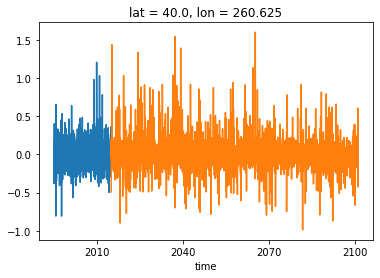

In [61]:
(hist_qdm - hist_qdm_cub).plot()
(sim_qdm - sim_qdm_cub).plot()

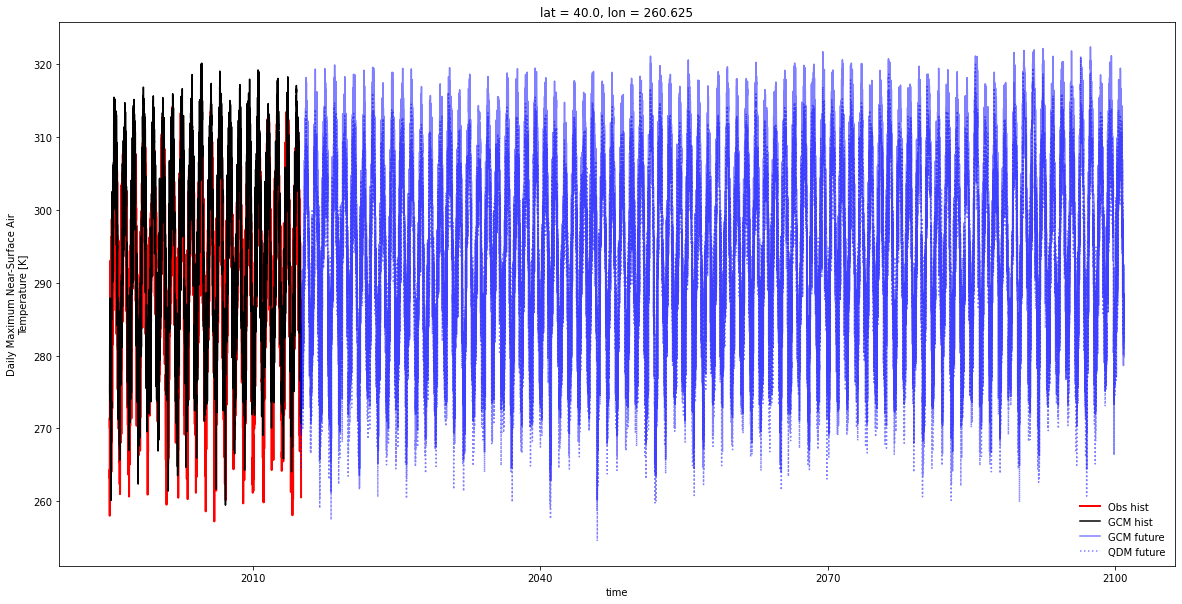

In [32]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ref.plot(ax=ax, linewidth=2, color="r", label="Obs hist")
hist.plot(ax=ax, color="k", label="GCM hist")
sim.plot(ax=ax, color="blue", label="GCM future", alpha=.5)
sim_qdm.plot(ax=ax, linestyle=':', color="blue", label="QDM future", alpha=.5)
ax.legend(frameon=False)

In [33]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*len(sim.time)) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*len(sim_qdm.time)) # total change

all days linear trend
  sim     3.5370877940542025
  QDM sim 3.8824834455781767


**Rolling CDF**

In [145]:
simy_qdm_list = []
#simy_qdm_lin_list = []
#simy_qdm_cub_list = []

roll = 10

# because we're rolling, we can't use the first and last 10 years
bc_years = np.arange(sim.time.dt.year.values[0]+roll,sim.time.dt.year.values[-1]-roll)

for yr in bc_years:
    timeslice = slice(str(yr-roll),str(yr+roll))
    
    # testing this on a future with a trend and one without
    simy_qdm_list.append(QDMdg.adjust(sim.sel(time=timeslice), interp='nearest', year=yr))
#    simy_qdm_lin_list.append(QDMdg.adjust(sim.sel(time=timeslice), interp='linear', year=yr))
#    simy_qdm_cub_list.append(QDMdg.adjust(sim.sel(time=timeslice), interp='cubic', year=yr))

simy_qdm = xr.concat(simy_qdm_list, dim='time')
#simy_lin_qdm = xr.concat(simy_qdm_lin_list, dim='time')
#simy_cub_qdm = xr.concat(simy_qdm_cub_list, dim='time')

In [50]:
QDMdg.ds

<xarray.Dataset>
Dimensions:    (dayofyear: 365, quantiles: 102)
Coordinates:
  * quantiles  (quantiles) float64 1e-06 0.005 0.015 0.025 ... 0.985 0.995 1.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    af         (dayofyear, quantiles) float64 -4.349 -3.277 ... 4.121 1.054
    hist_q     (dayofyear, quantiles) float64 262.4 264.1 267.0 ... 288.1 292.8
Attributes:
    adj_params:  QuantileDeltaMapping(nquantiles=100, kind='+', group=Grouper...

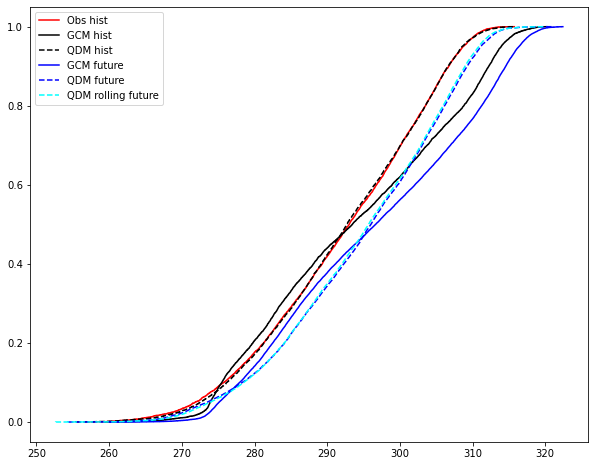

In [105]:
# interp = linear

import statsmodels.api as sm
    
ref_ecdf = sm.distributions.ECDF(ref)
hist_ecdf = sm.distributions.ECDF(hist)
sim_ecdf = sm.distributions.ECDF(sim)
histqdm_ecdf_lin = sm.distributions.ECDF(hist_qdm_lin)
simqdm_ecdf_lin = sm.distributions.ECDF(sim_qdm_lin)
simyqdm_ecdf_lin = sm.distributions.ECDF(simy_lin_qdm)

fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")
ax.step(histqdm_ecdf_lin.x,histqdm_ecdf_lin.y, color="k", linestyle='dashed', label="QDM hist")
ax.step(sim_ecdf.x,sim_ecdf.y, color="blue", label="GCM future")
ax.step(simqdm_ecdf_lin.x,simqdm_ecdf_lin.y, color="blue", linestyle='dashed', label="QDM future")
ax.step(simyqdm_ecdf_lin.x,simyqdm_ecdf_lin.y, color="cyan", linestyle='dashed', label="QDM rolling future")
ax.legend()

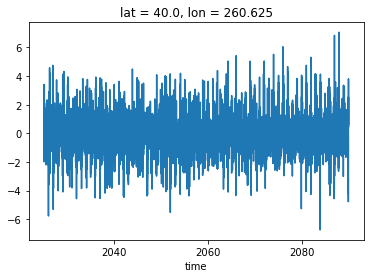

In [101]:
(sim_qdm_lin.sel(time=slice('2025-01-01','2089-12-31')) - simy_lin_qdm).plot()

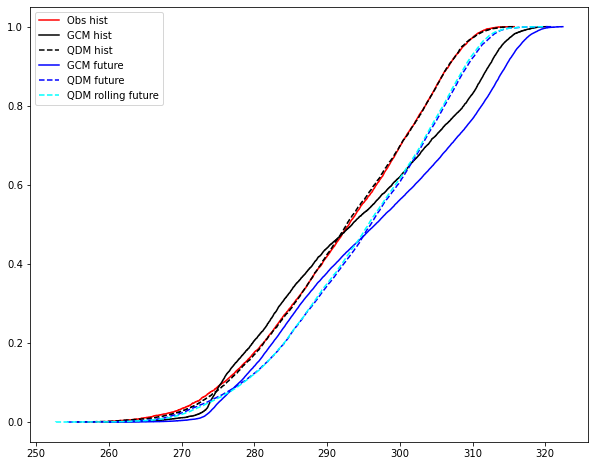

In [106]:
# interp = nearest

import statsmodels.api as sm
    
ref_ecdf = sm.distributions.ECDF(ref)
hist_ecdf = sm.distributions.ECDF(hist)
sim_ecdf = sm.distributions.ECDF(sim)
histqdm_ecdf = sm.distributions.ECDF(hist_qdm)
simqdm_ecdf = sm.distributions.ECDF(sim_qdm)
simyqdm_ecdf = sm.distributions.ECDF(simy_qdm)

fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")
ax.step(histqdm_ecdf.x,histqdm_ecdf.y, color="k", linestyle='dashed', label="QDM hist")
ax.step(sim_ecdf.x,sim_ecdf.y, color="blue", label="GCM future")
ax.step(simqdm_ecdf.x,simqdm_ecdf.y, color="blue", linestyle='dashed', label="QDM future")
ax.step(simyqdm_ecdf.x,simyqdm_ecdf.y, color="cyan", linestyle='dashed', label="QDM rolling future")
ax.legend()

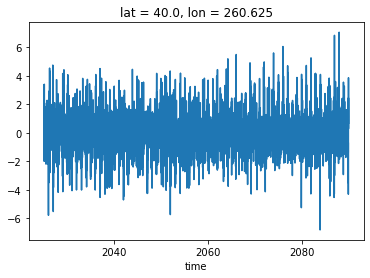

In [100]:
(sim_qdm.sel(time=slice('2025-01-01','2089-12-31')) - simy_qdm).plot()

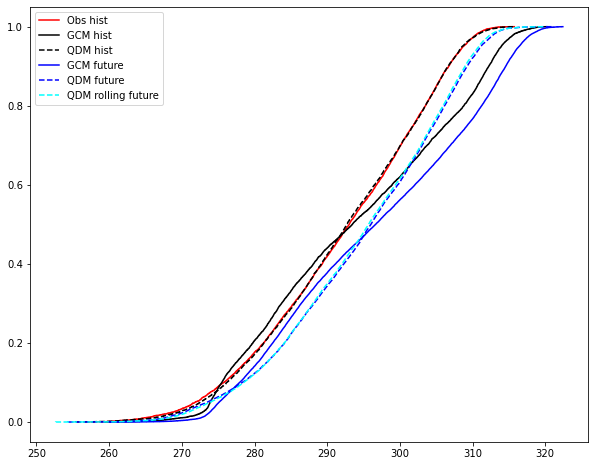

In [107]:
# interp = cubic

import statsmodels.api as sm
    
ref_ecdf = sm.distributions.ECDF(ref)
hist_ecdf = sm.distributions.ECDF(hist)
sim_ecdf = sm.distributions.ECDF(sim)
histqdm_ecdf_cub = sm.distributions.ECDF(hist_qdm_cub)
simqdm_ecdf_cub = sm.distributions.ECDF(sim_qdm_cub)
simyqdm_ecdf_cub = sm.distributions.ECDF(simy_cub_qdm)

fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")
ax.step(histqdm_ecdf_cub.x,histqdm_ecdf_cub.y, color="k", linestyle='dashed', label="QDM hist")
ax.step(sim_ecdf.x,sim_ecdf.y, color="blue", label="GCM future")
ax.step(simqdm_ecdf_cub.x,simqdm_ecdf_cub.y, color="blue", linestyle='dashed', label="QDM future")
ax.step(simyqdm_ecdf_cub.x,simyqdm_ecdf_cub.y, color="cyan", linestyle='dashed', label="QDM rolling future")
ax.legend()

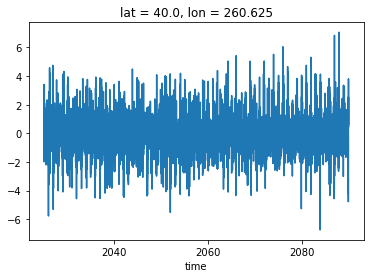

In [103]:
(sim_qdm_cub.sel(time=slice('2025-01-01','2089-12-31')) - simy_cub_qdm).plot()

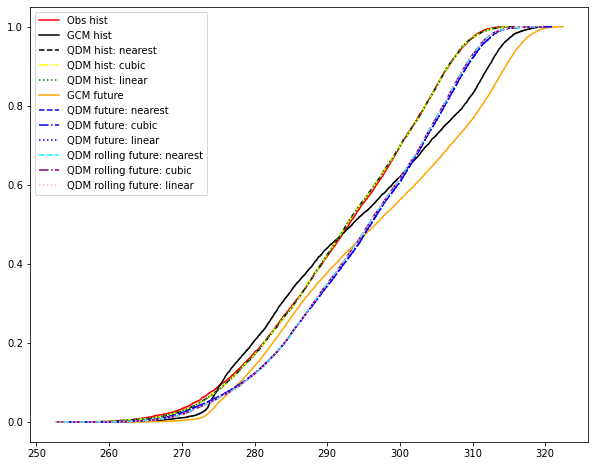

In [108]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")

# different interp methods
ax.step(histqdm_ecdf.x,histqdm_ecdf.y, color="k", linestyle='dashed', label="QDM hist: nearest")
ax.step(histqdm_ecdf_cub.x,histqdm_ecdf_cub.y, color="yellow", linestyle='-.', label="QDM hist: cubic")
ax.step(histqdm_ecdf_lin.x,histqdm_ecdf_lin.y, color="green", linestyle='dotted', label="QDM hist: linear")

ax.step(sim_ecdf.x,sim_ecdf.y, color="orange", label="GCM future")
ax.step(simqdm_ecdf.x,simqdm_ecdf.y, color="blue", linestyle='dashed', label="QDM future: nearest")
ax.step(simqdm_ecdf_cub.x,simqdm_ecdf_cub.y, color="blue", linestyle='-.', label="QDM future: cubic")
ax.step(simqdm_ecdf_lin.x,simqdm_ecdf_lin.y, color="blue", linestyle='dotted', label="QDM future: linear")

ax.step(simyqdm_ecdf.x,simyqdm_ecdf.y, color="cyan", linestyle='dashed', label="QDM rolling future: nearest")
ax.step(simyqdm_ecdf_cub.x,simyqdm_ecdf_cub.y, color="purple", linestyle='-.', label="QDM rolling future: cubic")
ax.step(simyqdm_ecdf_lin.x,simyqdm_ecdf_lin.y, color="pink", linestyle='dotted', label="QDM rolling future: linear")

ax.legend()

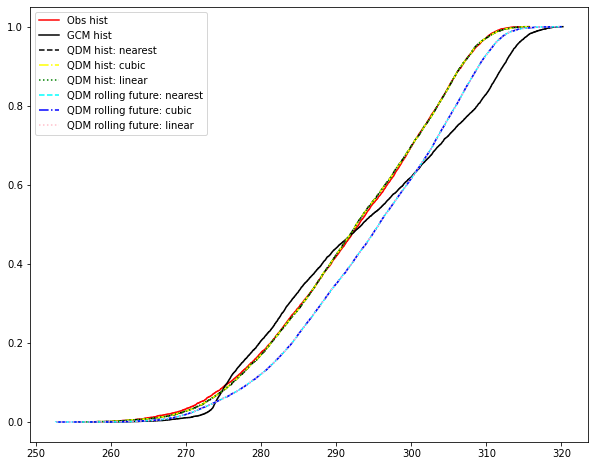

In [133]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

ax.step(ref_ecdf.x,ref_ecdf.y, color="r", label="Obs hist")
ax.step(hist_ecdf.x,hist_ecdf.y, color="k", label="GCM hist")

# different interp methods
ax.step(histqdm_ecdf.x,histqdm_ecdf.y, color="k", linestyle='dashed', label="QDM hist: nearest")
ax.step(histqdm_ecdf_cub.x,histqdm_ecdf_cub.y, color="yellow", linestyle='-.', label="QDM hist: cubic")
ax.step(histqdm_ecdf_lin.x,histqdm_ecdf_lin.y, color="green", linestyle='dotted', label="QDM hist: linear")

ax.step(sim_ecdf.x,sim_ecdf.y, color="blue", label="GCM future")
ax.step(simqdm_ecdf.x,simqdm_ecdf.y, color="blue", linestyle='dashed', label="QDM future: nearest")
ax.step(simqdm_ecdf_cub.x,simqdm_ecdf_cub.y, color="blue", linestyle='-.', label="QDM future: cubic")
ax.step(simqdm_ecdf_lin.x,simqdm_ecdf_lin.y, color="blue", linestyle='dotted', label="QDM future: linear")

ax.step(simyqdm_ecdf.x,simyqdm_ecdf.y, color="cyan", linestyle='dashed', label="QDM rolling future: nearest")
ax.step(simyqdm_ecdf_cub.x,simyqdm_ecdf_cub.y, color="purple", linestyle='-.', label="QDM rolling future: cubic")
ax.step(simyqdm_ecdf_lin.x,simyqdm_ecdf_lin.y, color="pink", linestyle='dotted', label="QDM rolling future: linear")

ax.legend()

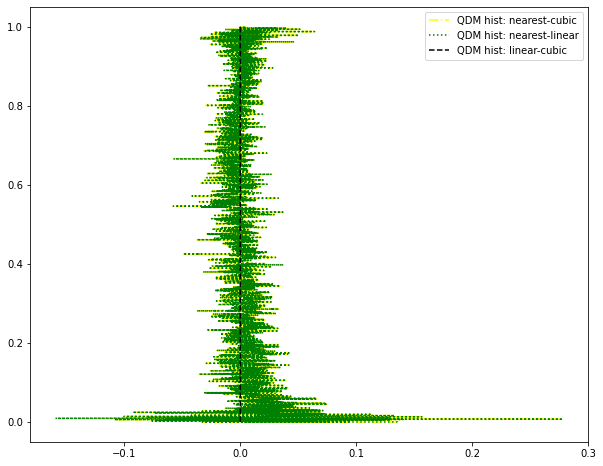

In [111]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.step((histqdm_ecdf.x - histqdm_ecdf_cub.x),histqdm_ecdf_cub.y, color="yellow", linestyle='-.', label="QDM hist: nearest-cubic")
ax.step((histqdm_ecdf.x - histqdm_ecdf_lin.x),histqdm_ecdf_lin.y, color="green", linestyle='dotted', label="QDM hist: nearest-linear")
ax.step((histqdm_ecdf_lin.x - histqdm_ecdf_cub.x),histqdm_ecdf.y, color="k", linestyle='dashed', label="QDM hist: linear-cubic")
ax.legend()

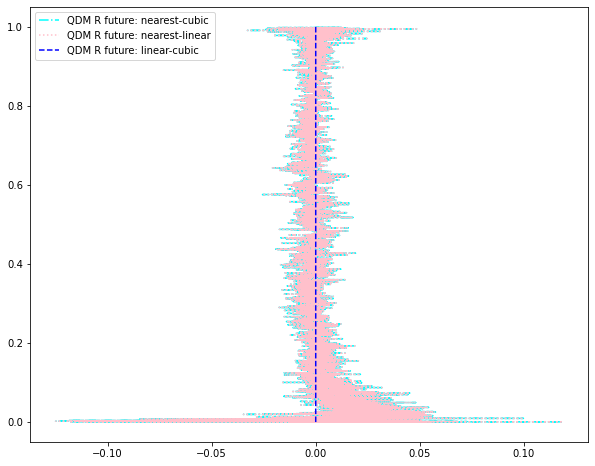

In [110]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.step((simyqdm_ecdf.x - simyqdm_ecdf_cub.x),simyqdm_ecdf_cub.y, color="cyan", linestyle='-.', label="QDM R future: nearest-cubic")
ax.step((simyqdm_ecdf.x - simyqdm_ecdf_lin.x),simyqdm_ecdf_lin.y, color="pink", linestyle='dotted', label="QDM R future: nearest-linear")
ax.step((simyqdm_ecdf_lin.x - simyqdm_ecdf_cub.x),simyqdm_ecdf.y, color="blue", linestyle='dashed', label="QDM R future: linear-cubic")
ax.legend()

In [62]:
sim_qdm

<xarray.DataArray (time: 31390)>
array([264.57814453, 271.87766113, 271.9142218 , ..., 289.94381012,
       288.03995743, 291.05753845])
Coordinates:
    lat        float64 40.0
    lon        float64 260.6
  * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-11-15T10:38:50Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    xclim_history:  2019-11-15T10:38:50Z altered by CMOR: Treated scalar dime...

In [63]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*len(sim.time)) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*len(sim_qdm.time)) # total change
print('  QDM rolling sim', sp.stats.linregress(np.arange(len(simy_qdm.time)), simy_qdm.values).slope*len(simy_qdm.time)) # total change

all days linear trend
  sim     3.5370877940542025
  QDM sim 3.8824834455781767
  QDM rolling sim 2.627080358961063


**Are the trends preserved across quantiles?**

In [82]:
simy_qdm.time #.sel(time=slice('2025-01-01 12:00:00.000000000','2040-12-31 12:00:00.000000000'))

<xarray.DataArray 'time' (time: 23725)>
array([cftime.DatetimeNoLeap(2025, 1, 1, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2025, 1, 2, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2025, 1, 3, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2089, 12, 29, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2089, 12, 30, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2089, 12, 31, 12, 0, 0, 0)], dtype=object)
Coordinates:
    lat      float64 40.0
    lon      float64 260.6
  * time     (time) object 2025-01-01 12:00:00 ... 2089-12-31 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

In [130]:
from plotting import quantile_compare_plot, compare_quantile_deltas_scatter_hist, compare_gcm_qdm_quantile_deltas, plot_quantile_delta_differences_by_group

In [131]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim}
adjusted_dict = {'hist':hist_qdm,
                'sim':simy_qdm}
bcgrouper = QDMdg.group

Quantile number = 100 -- Denver, CO.

In [155]:
sim_qdm.sel(time=slice('2080','2100')).quantile([0.05,0.5,0.95])

<xarray.DataArray (quantile: 3)>
array([275.10351067, 297.10967827, 312.46286663])
Coordinates:
  * quantile  (quantile) float64 0.05 0.5 0.95

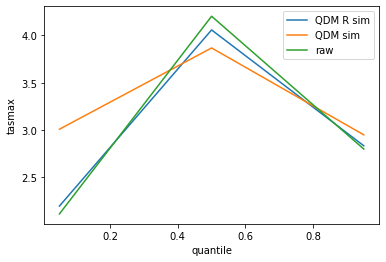

In [157]:
(simy_qdm.sel(time=slice('2060','2080')).quantile([0.05,0.5,0.95]) - hist_qdm.quantile([0.05,0.5,0.95])).plot(label="QDM R sim")
(sim_qdm.sel(time=slice('2060','2080')).quantile([0.05,0.5,0.95]) - hist_qdm.quantile([0.05,0.5,0.95])).plot(label='QDM sim')
(sim.sel(time=slice('2060','2080')).quantile([0.05,0.5,0.95]) - hist.quantile([0.05,0.5,0.95])).plot(label="raw")
plt.legend()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

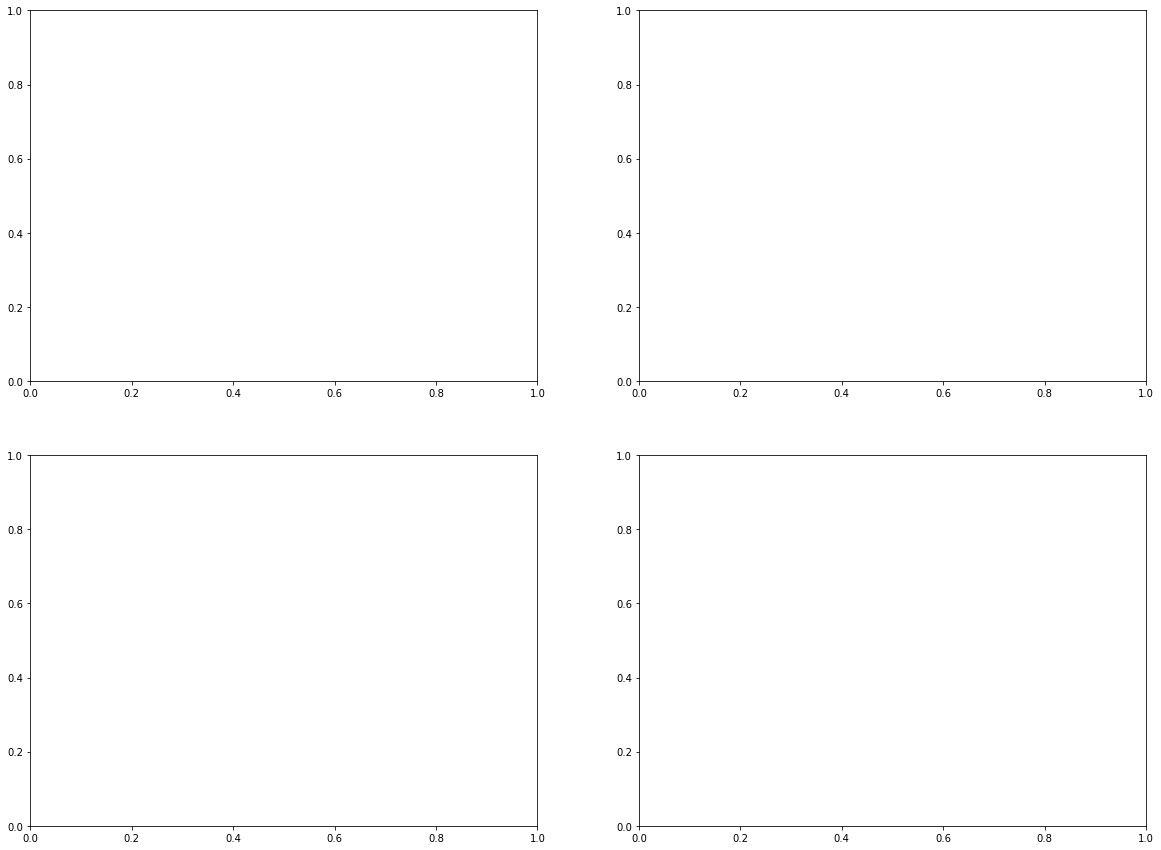

In [132]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

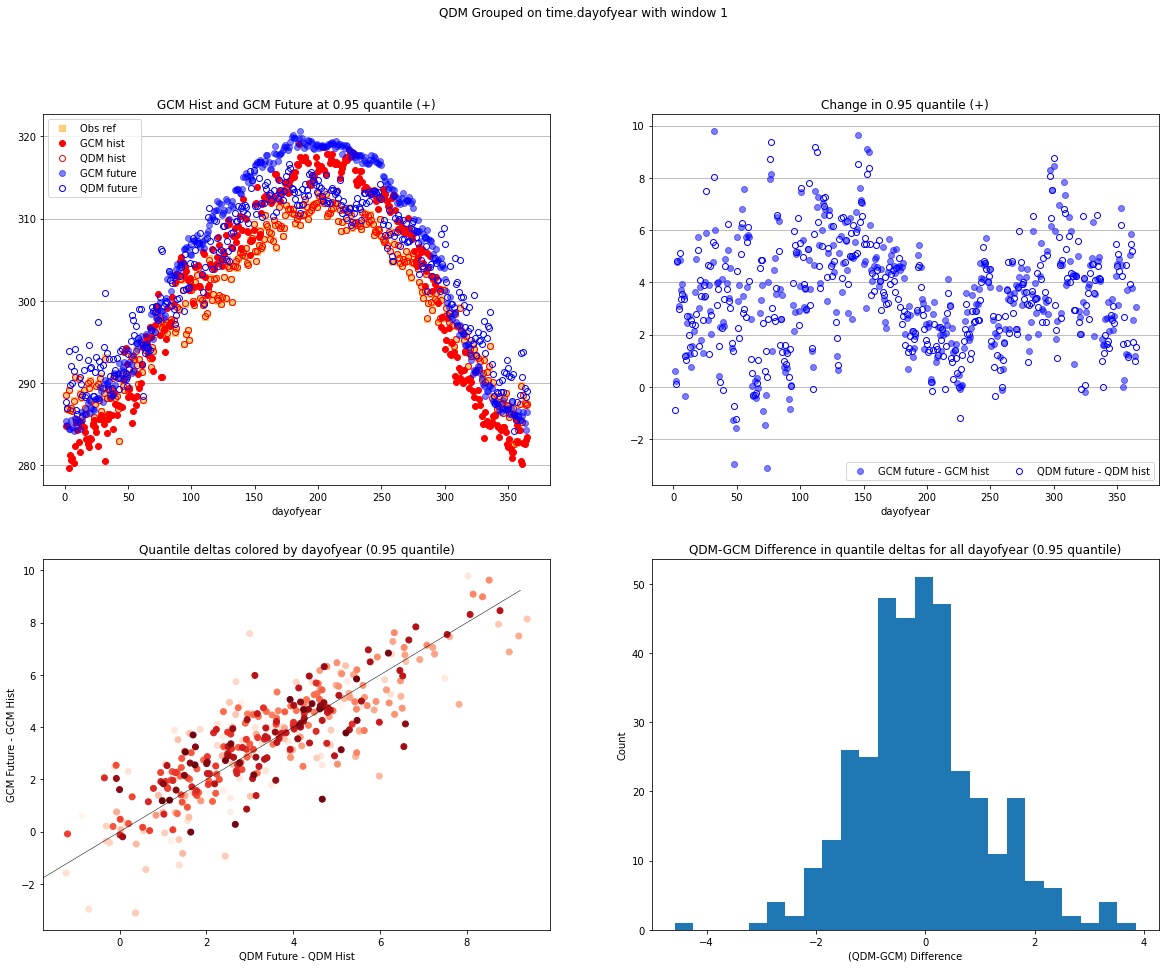

In [90]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

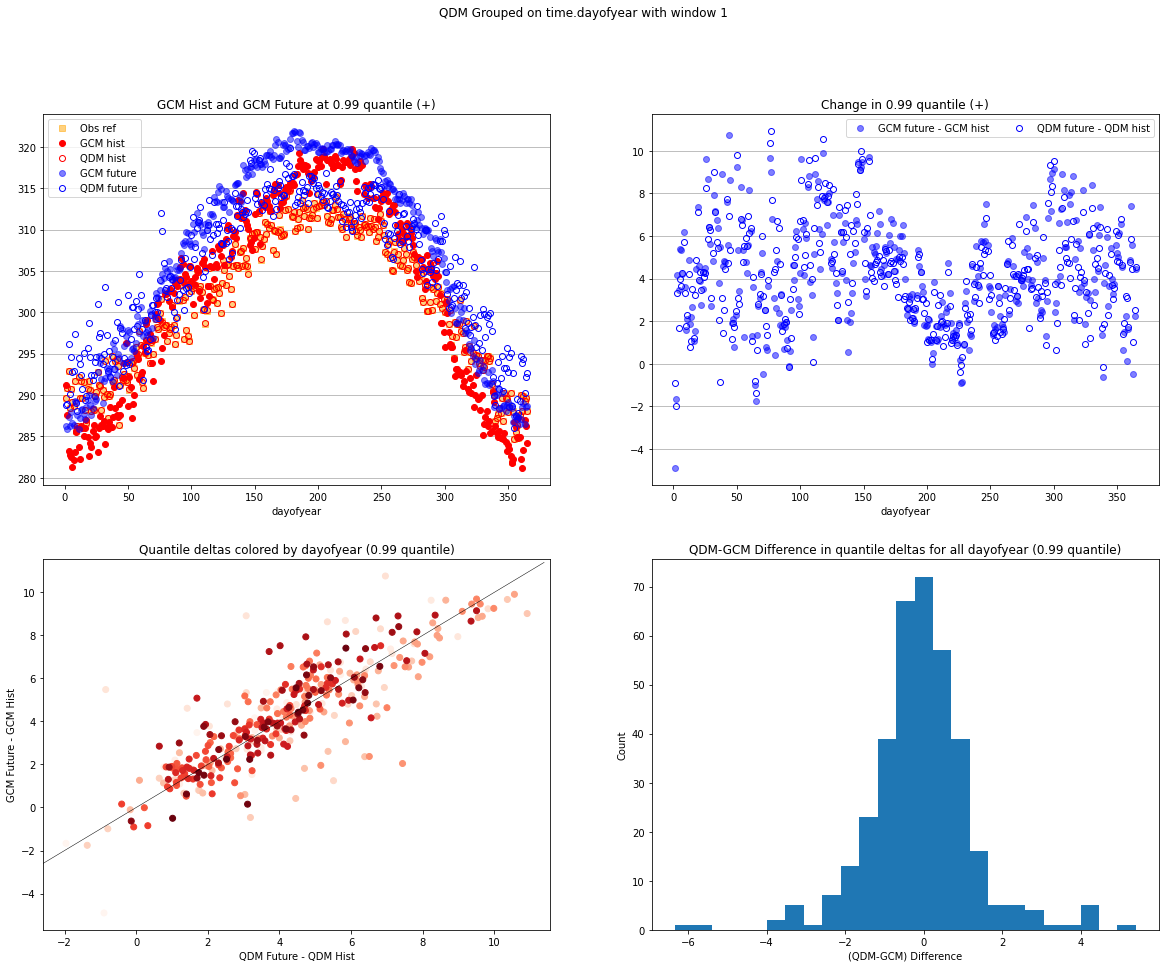

In [91]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

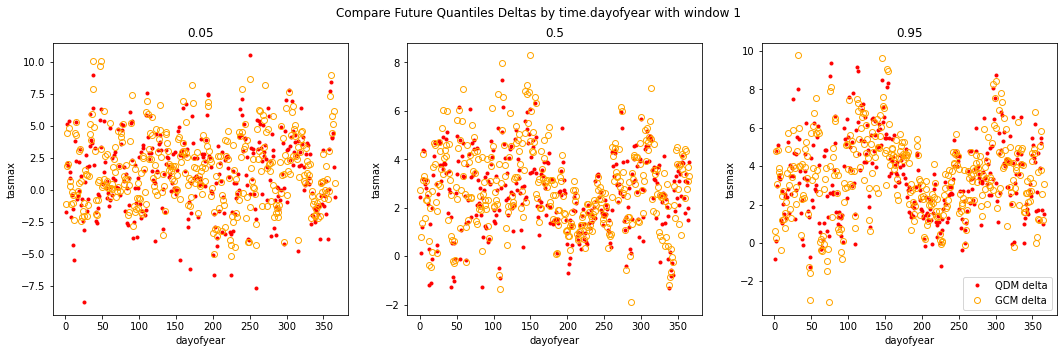

In [92]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

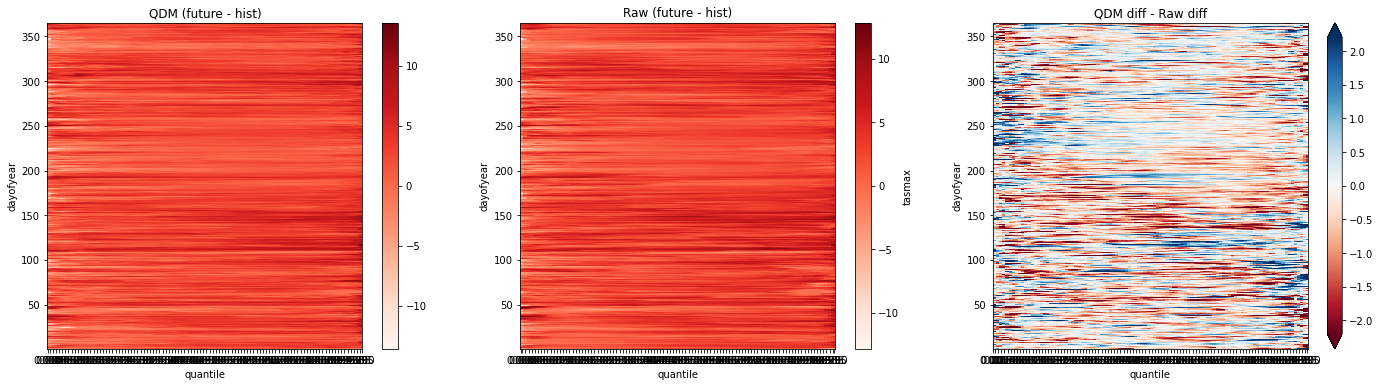

In [93]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=QDMdg.ds.quantiles)

In [74]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim.sel(time=slice('2080-01-01T12:00:00.000000000','2100-12-31T12:00:00.000000000'))}
adjusted_dict = {'hist':hist_qdm,
                'sim':sim_qdm.sel(time=slice('2080-01-01T12:00:00.000000000','2100-12-31T12:00:00.000000000'))}
bcgrouper = QDMdg.group

Denver, CO n=100, sim:2080-2100

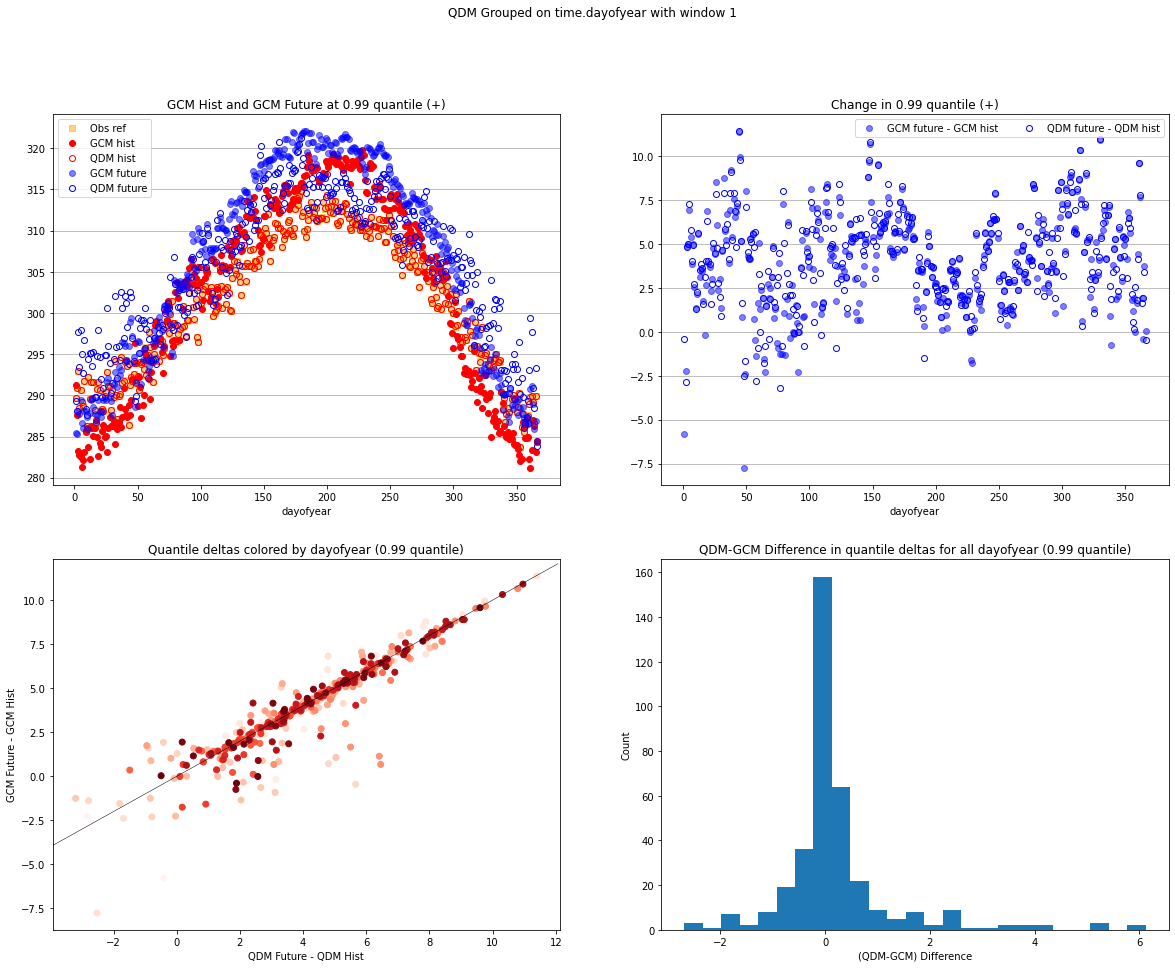

In [76]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

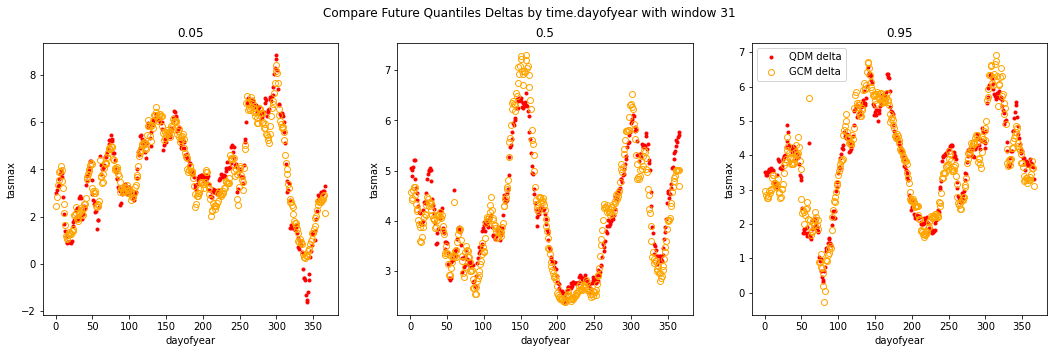

In [53]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

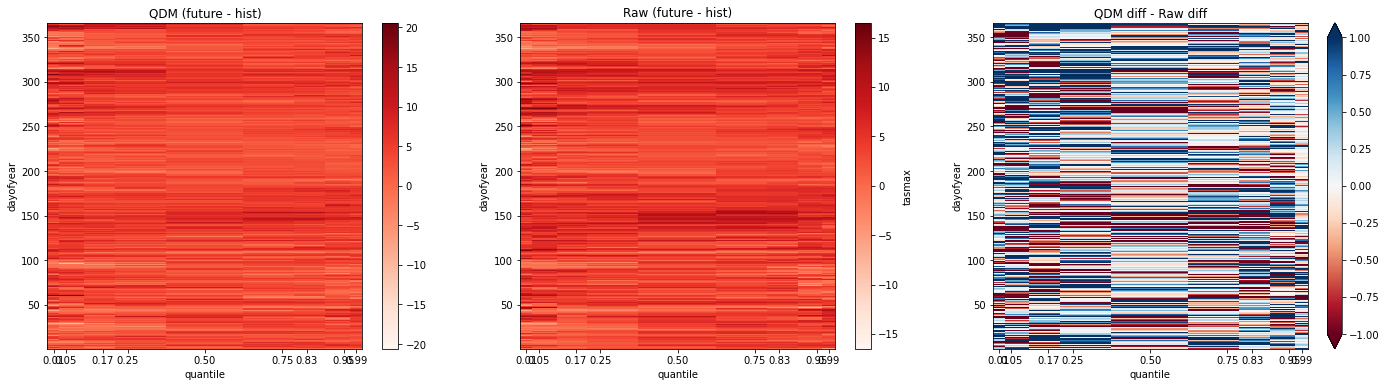

In [75]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.01,.05,.17,.25,.5,.75,.83,.95,.99])

In [55]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim.sel(time=slice('2040-01-01T12:00:00.000000000','2060-12-31T12:00:00.000000000'))}
adjusted_dict = {'hist':hist_qdm,
                'sim':sim_qdm.sel(time=slice('2040-01-01T12:00:00.000000000','2060-12-31T12:00:00.000000000'))}
bcgrouper = QDMdg.group

Denver, CO n=100, sim:2040-2060

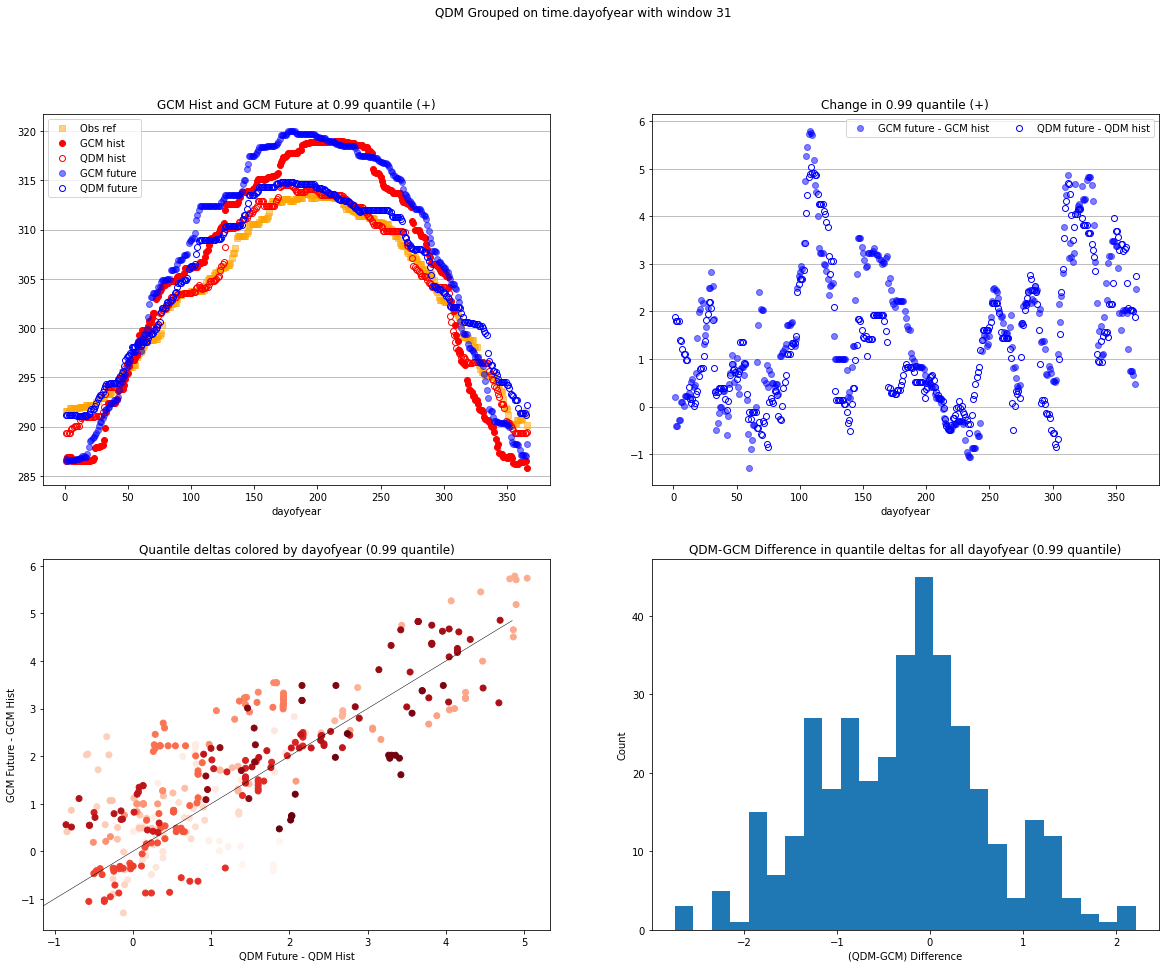

In [56]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

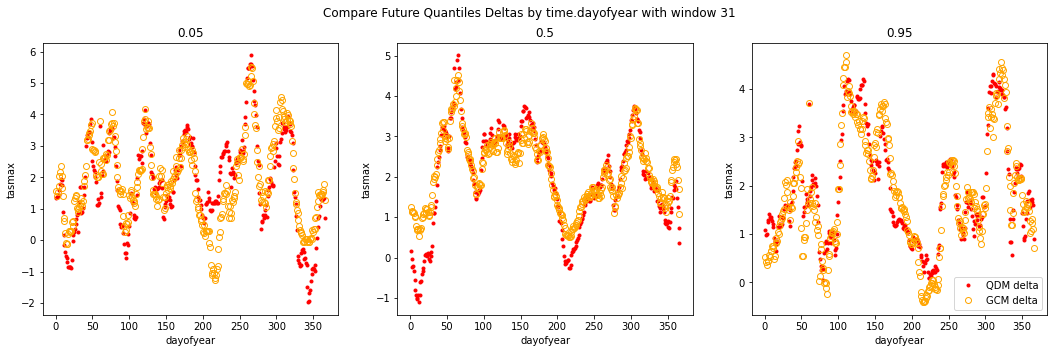

In [57]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

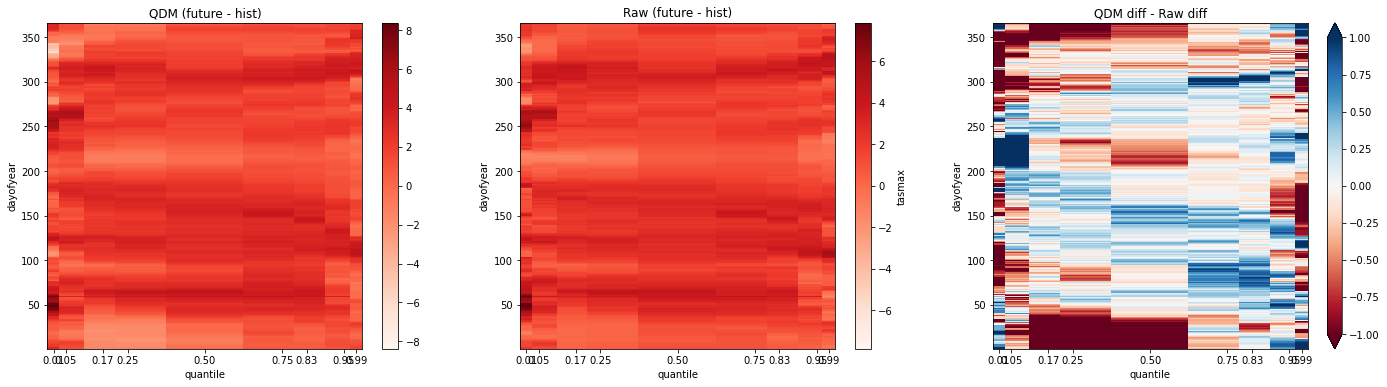

In [58]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.01,.05,.17,.25,.5,.75,.83,.95,.99])

In [91]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim}
adjusted_dict = {'hist':hist_qdm,
                'sim':sim_qdm}
bcgrouper = QDMdg.group

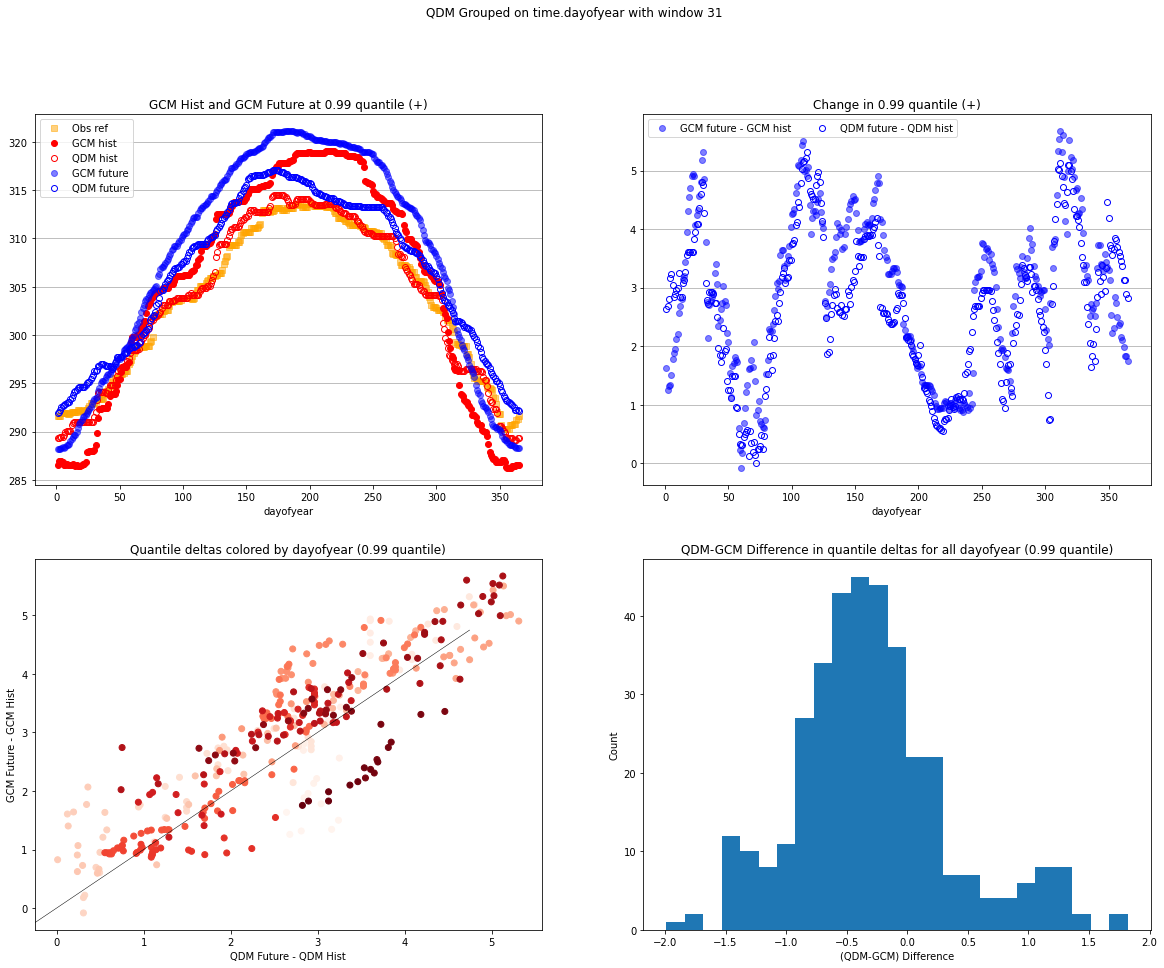

In [92]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

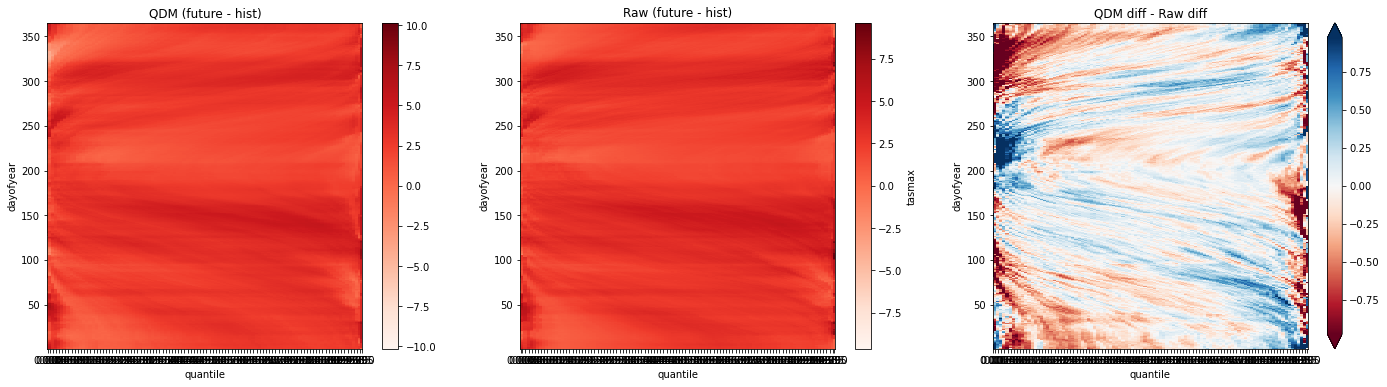

In [93]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=QDMdg.ds.quantiles)

Quantile number = 100 -- Miami, FL

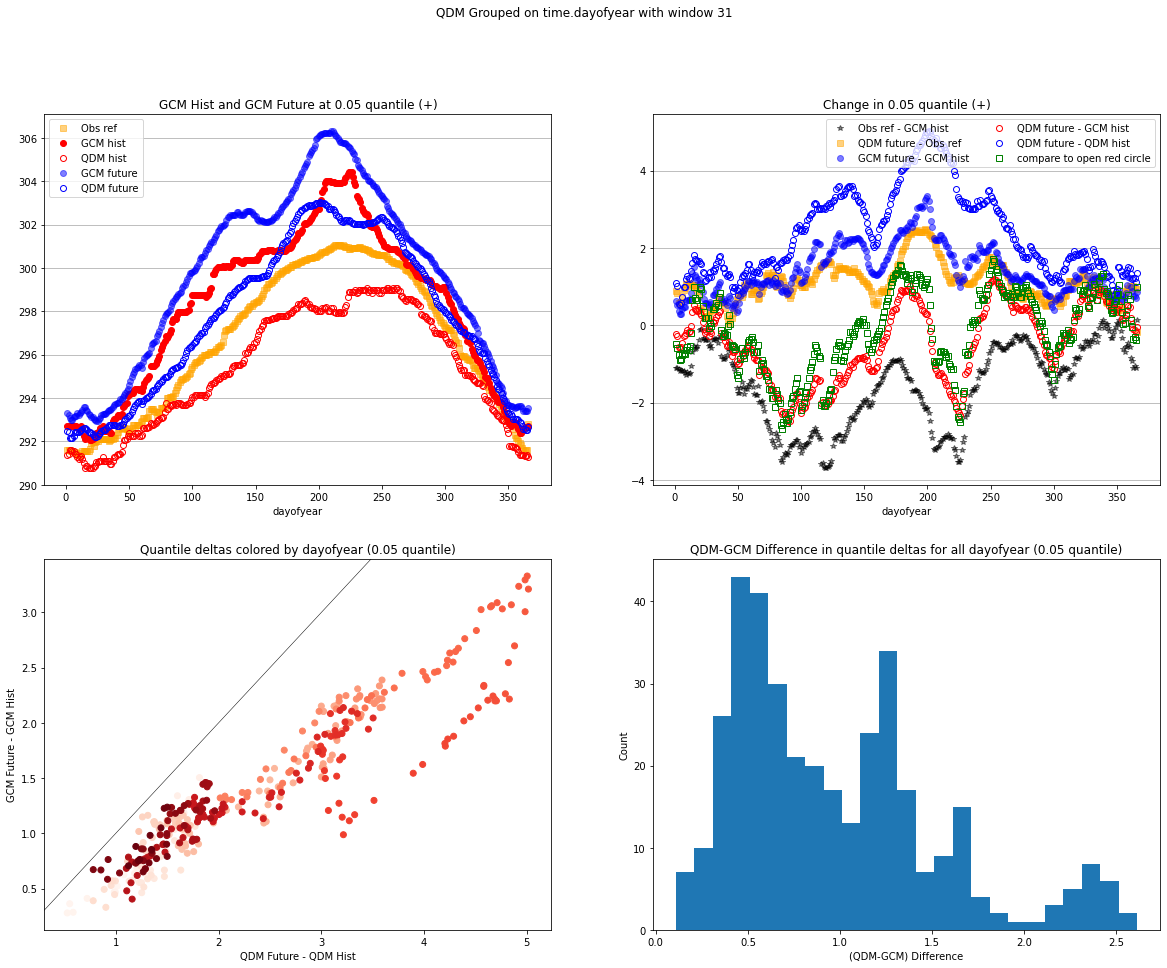

In [38]:
printtofile=False

_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.05], tworow=True)

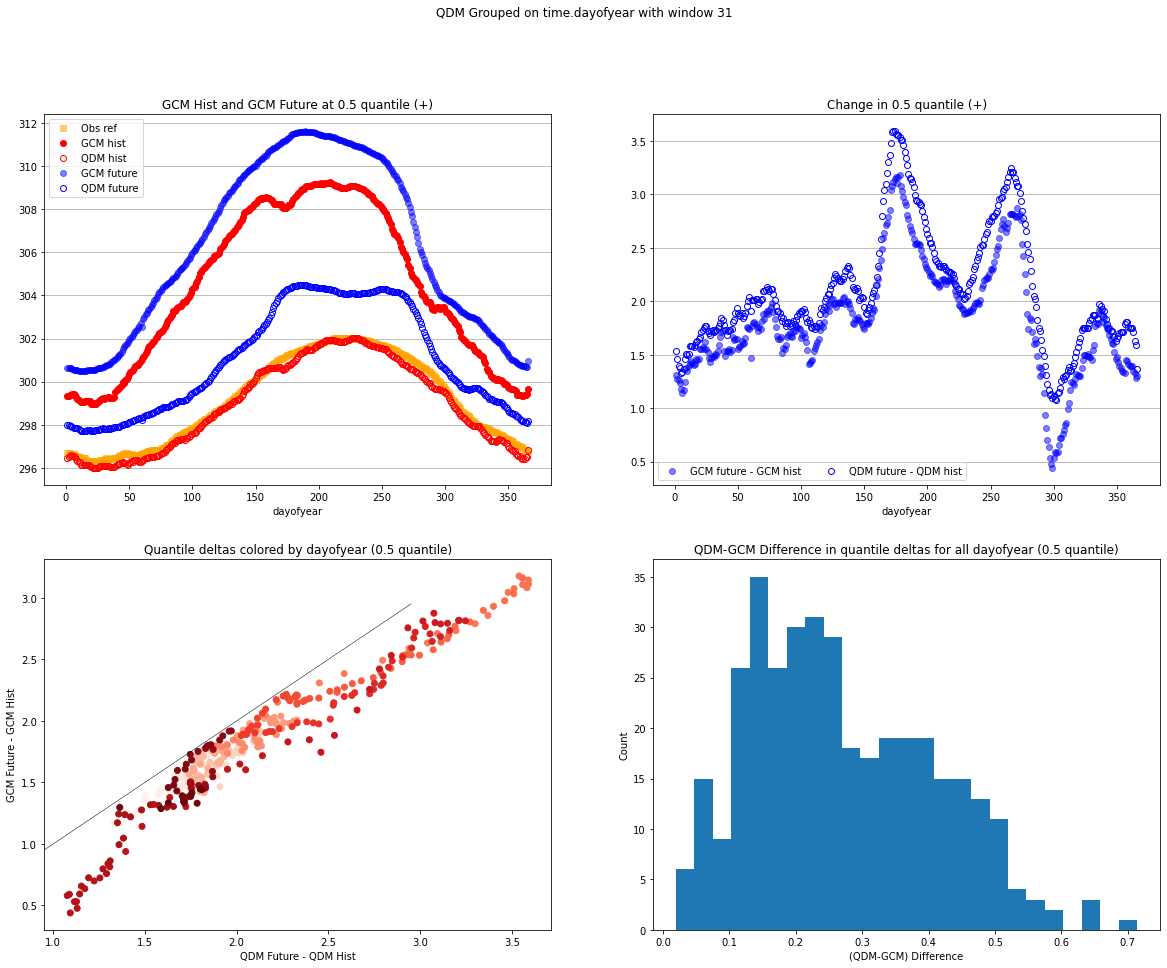

In [45]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

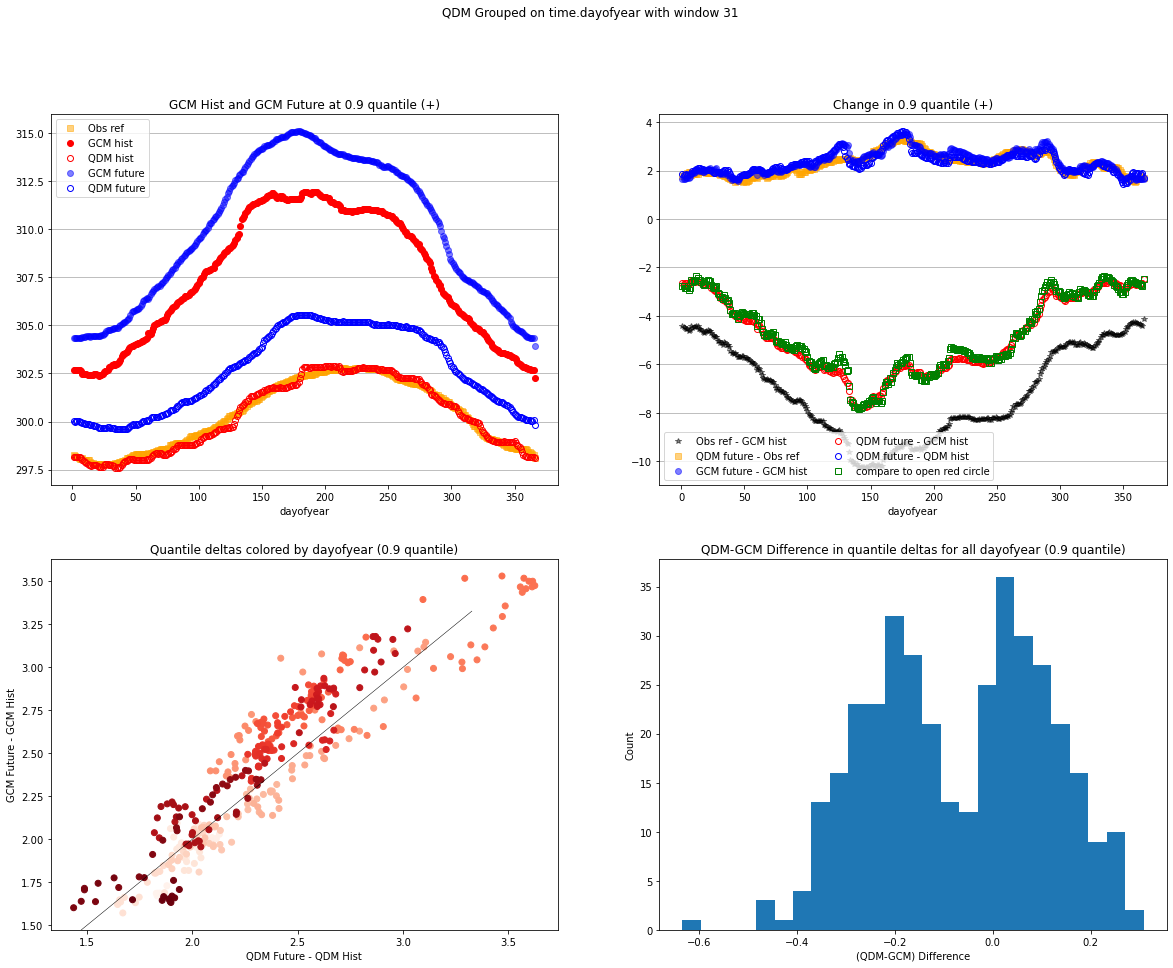

In [40]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.90], tworow=True)

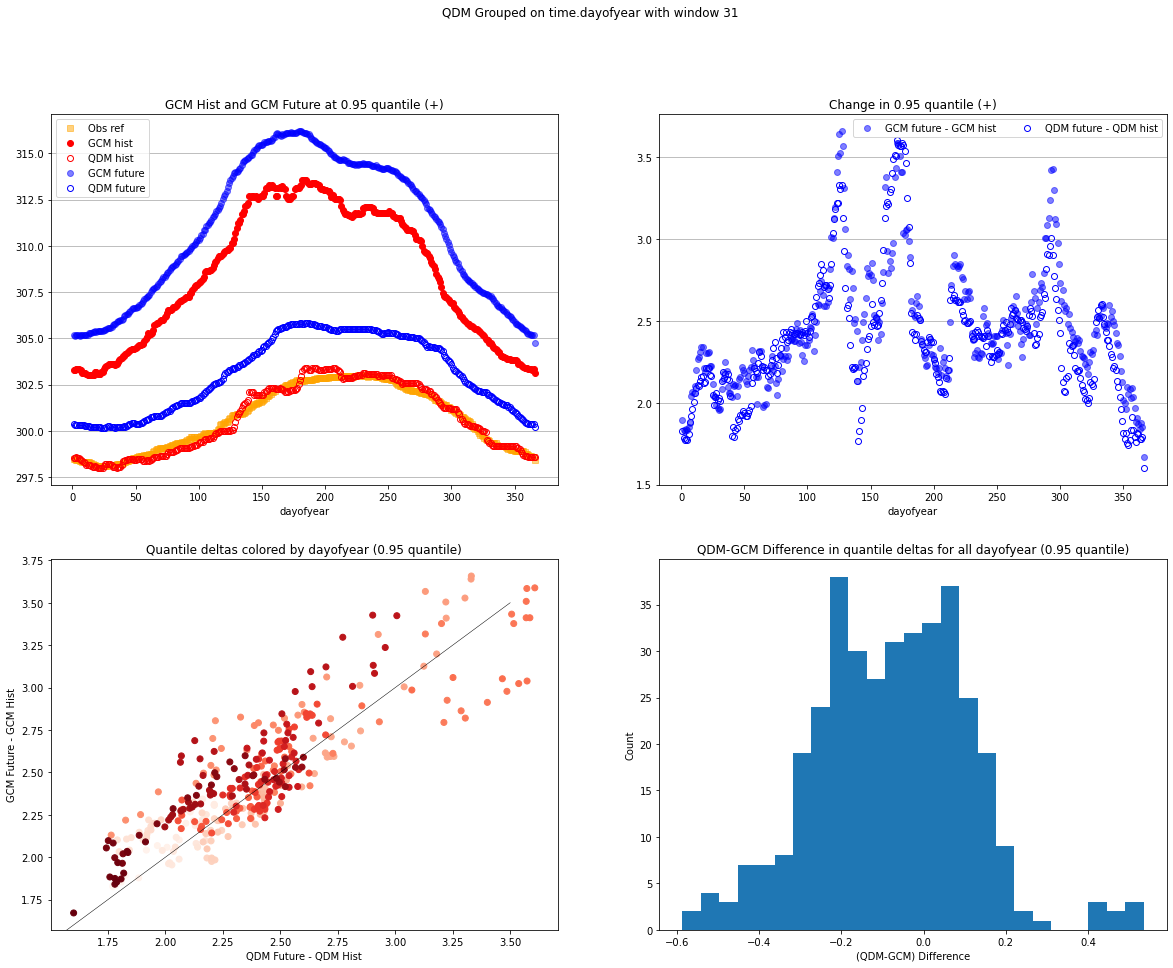

In [46]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

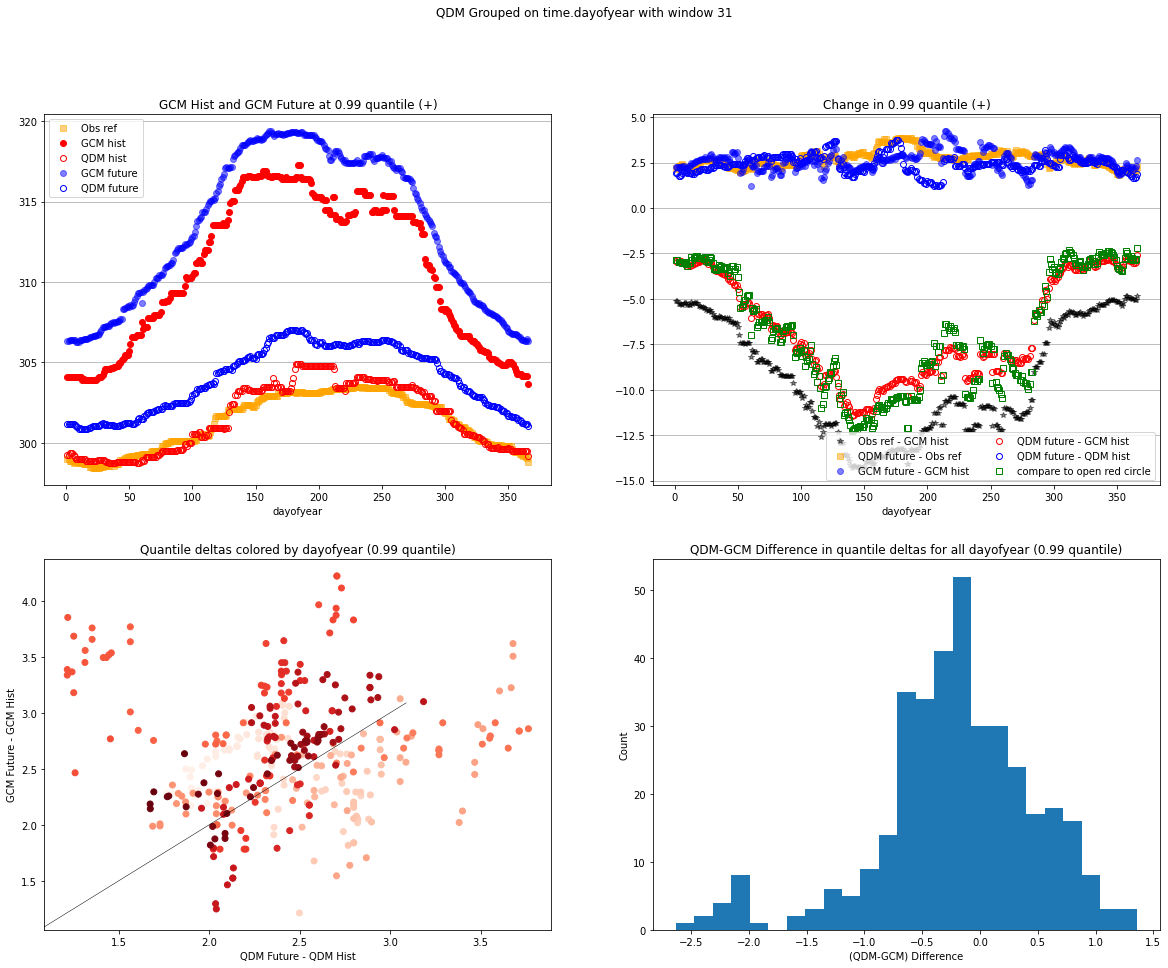

In [42]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], tworow=True)

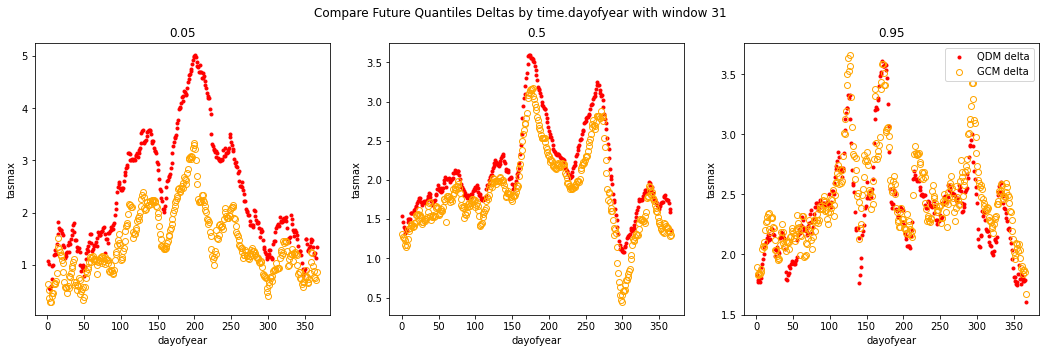

In [43]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

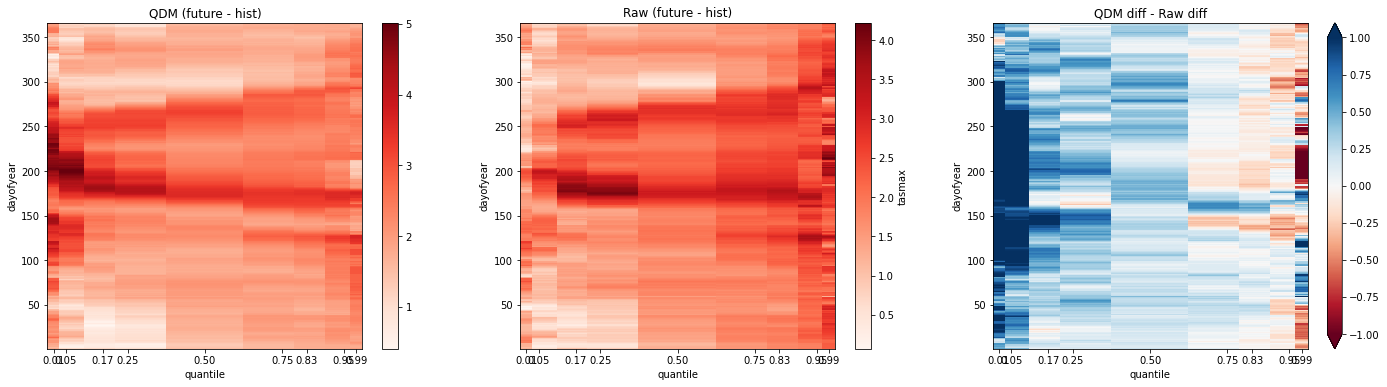

In [44]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.01,.05,.17,.25,.5,.75,.83,.95,.99])

Quantile number = 200

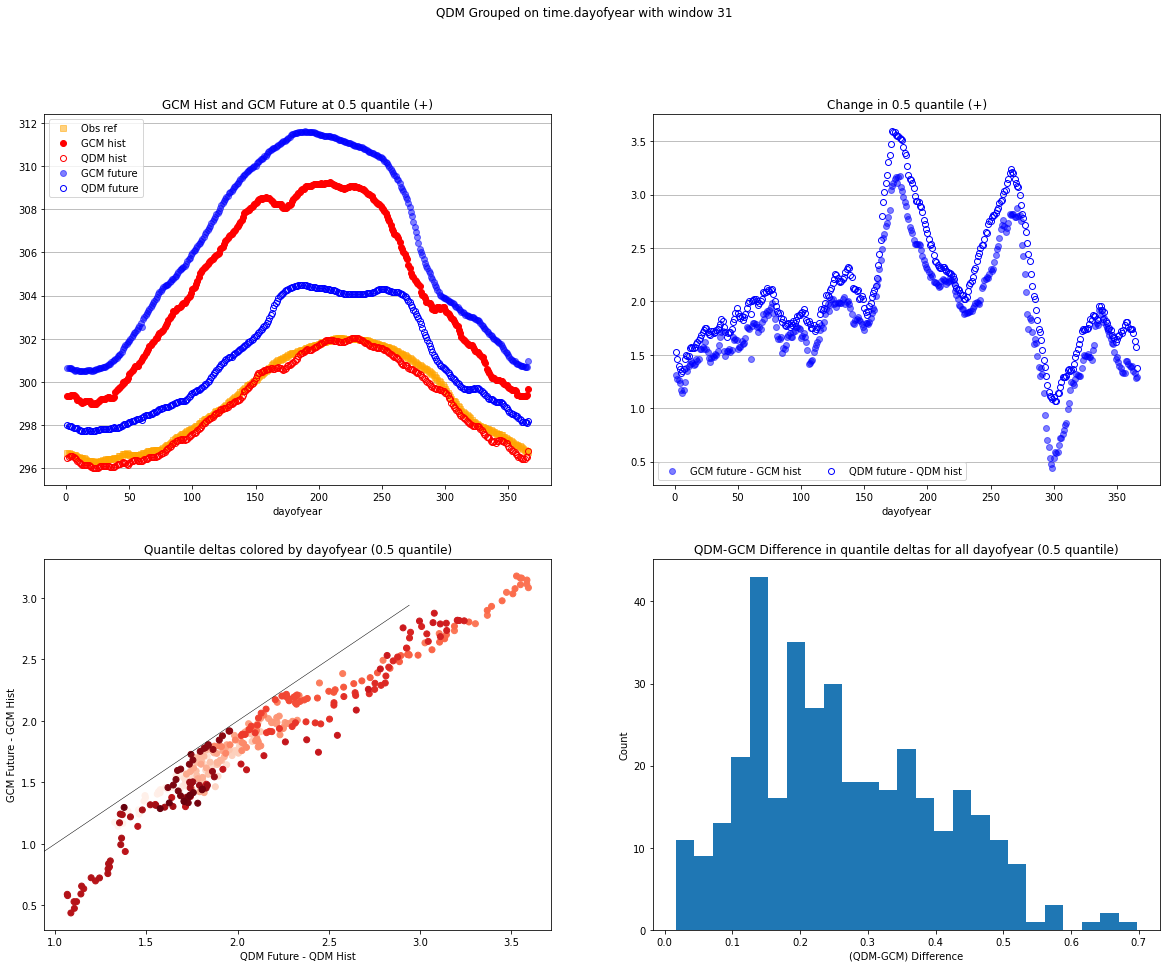

In [55]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

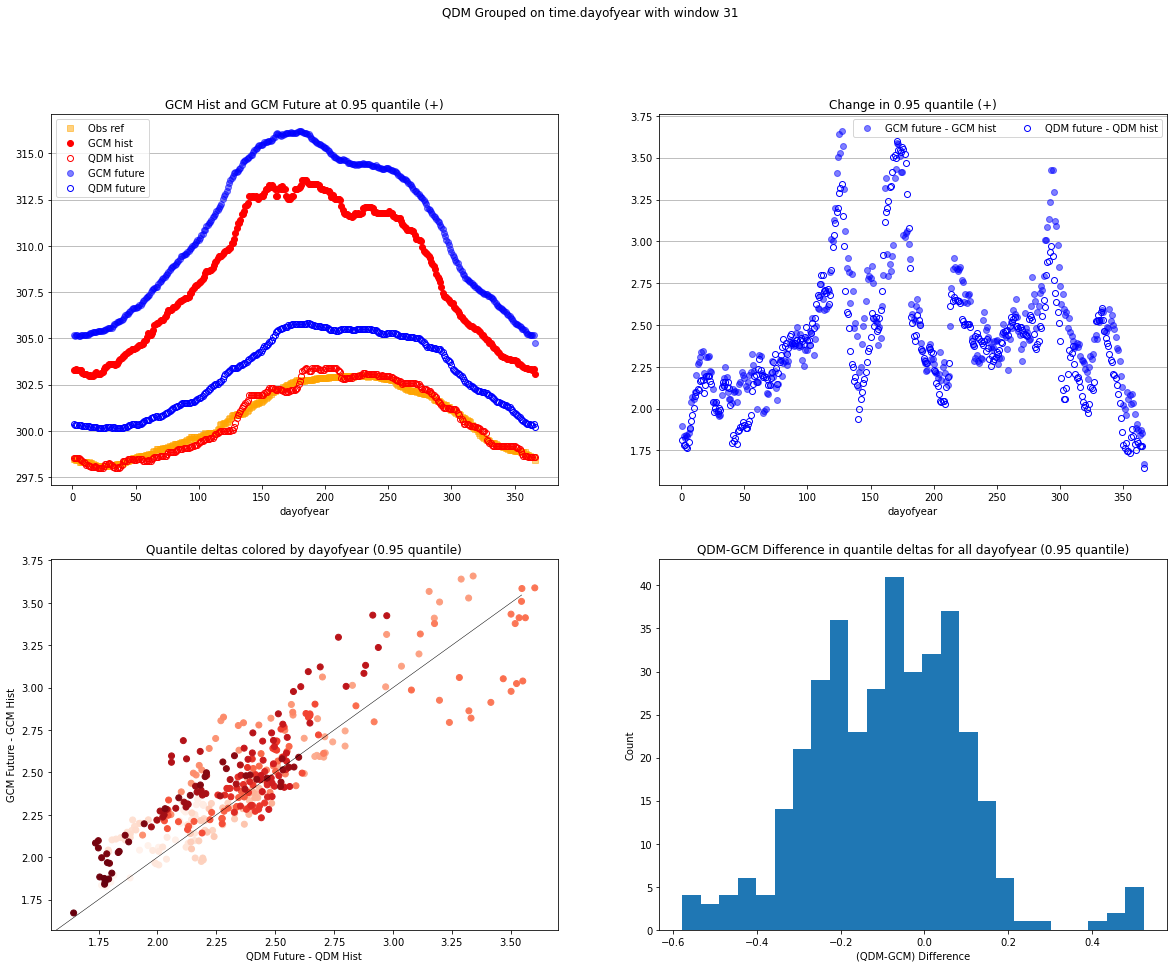

In [56]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

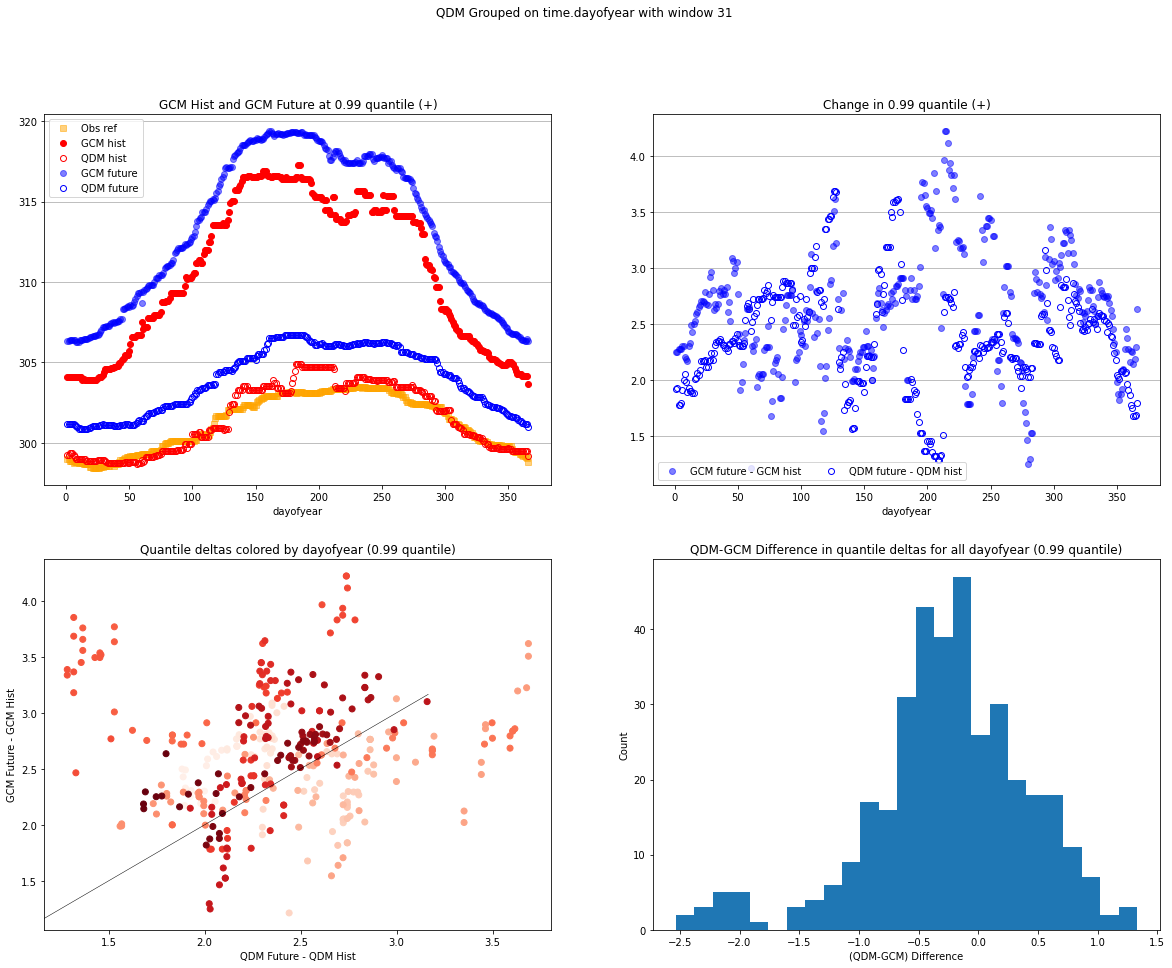

In [57]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

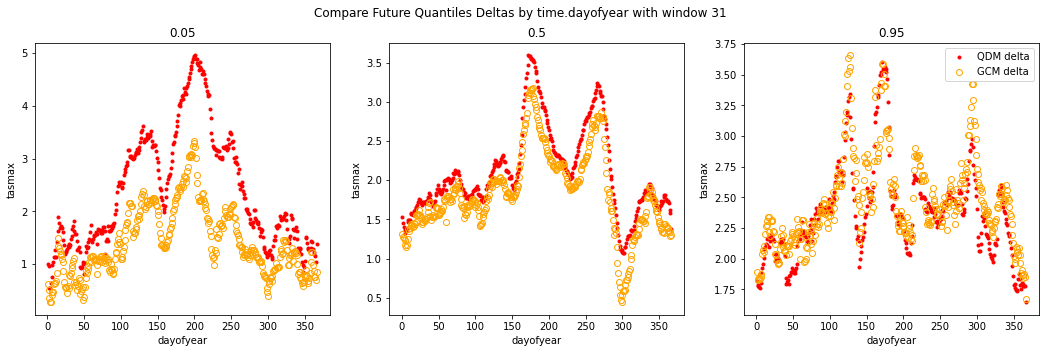

In [58]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

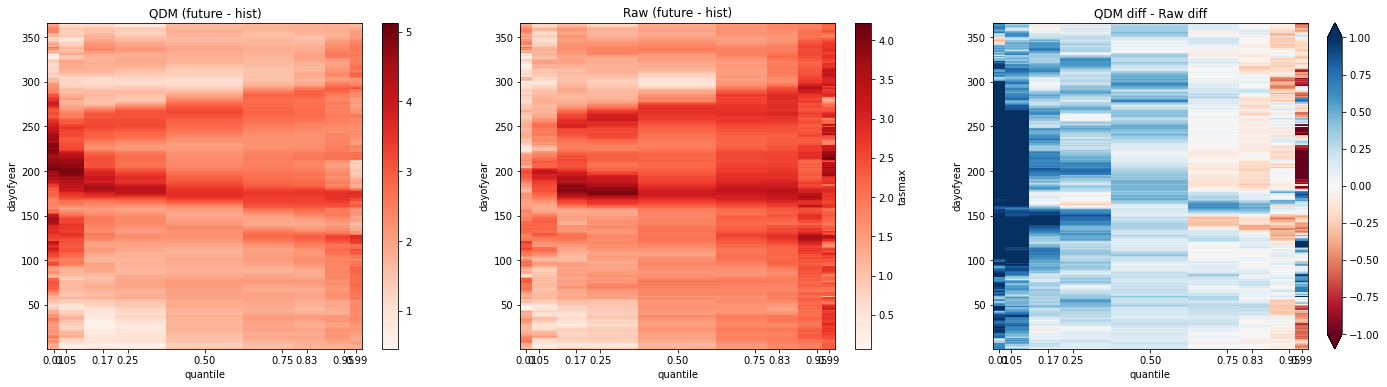

In [59]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.01,.05,.17,.25,.5,.75,.83,.95,.99])

Quantile number = 300

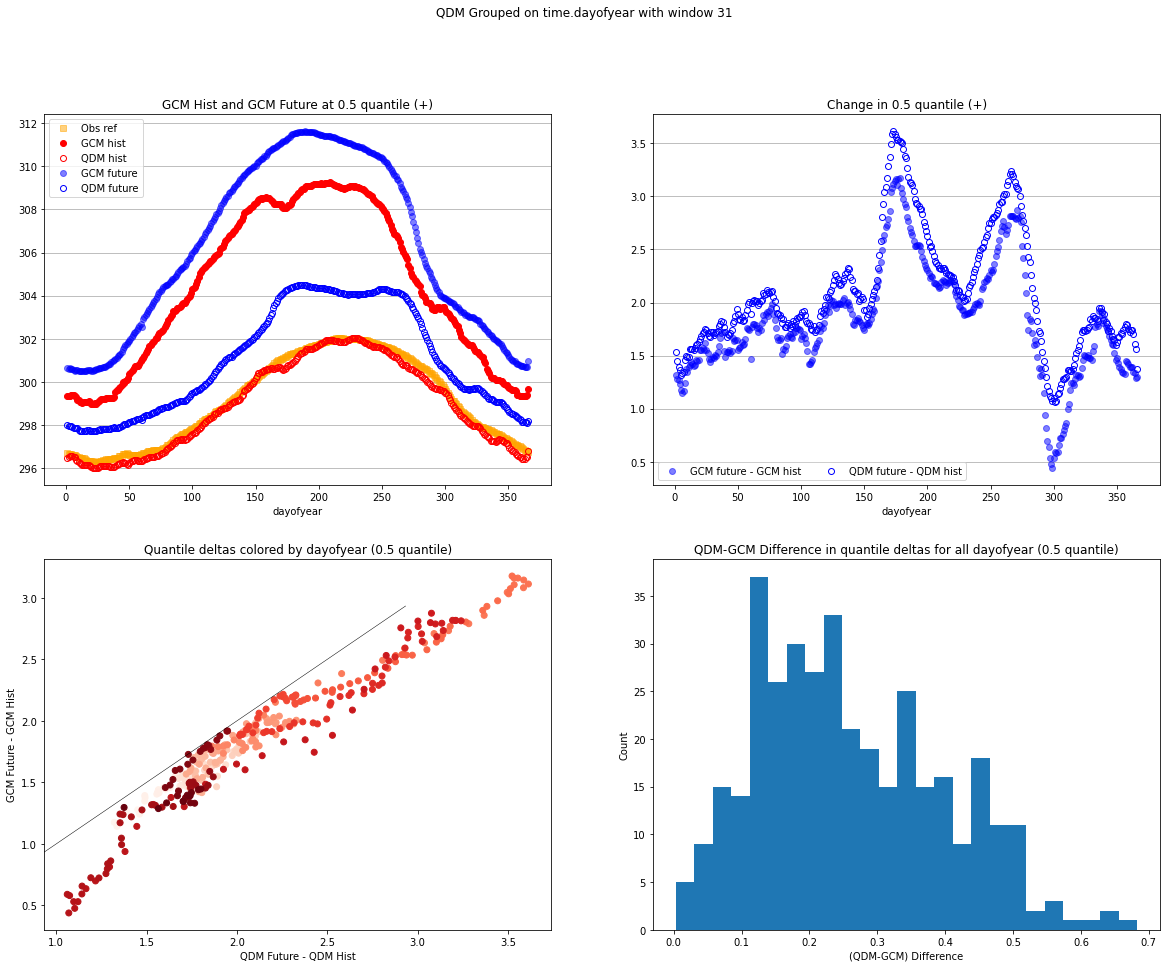

In [68]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

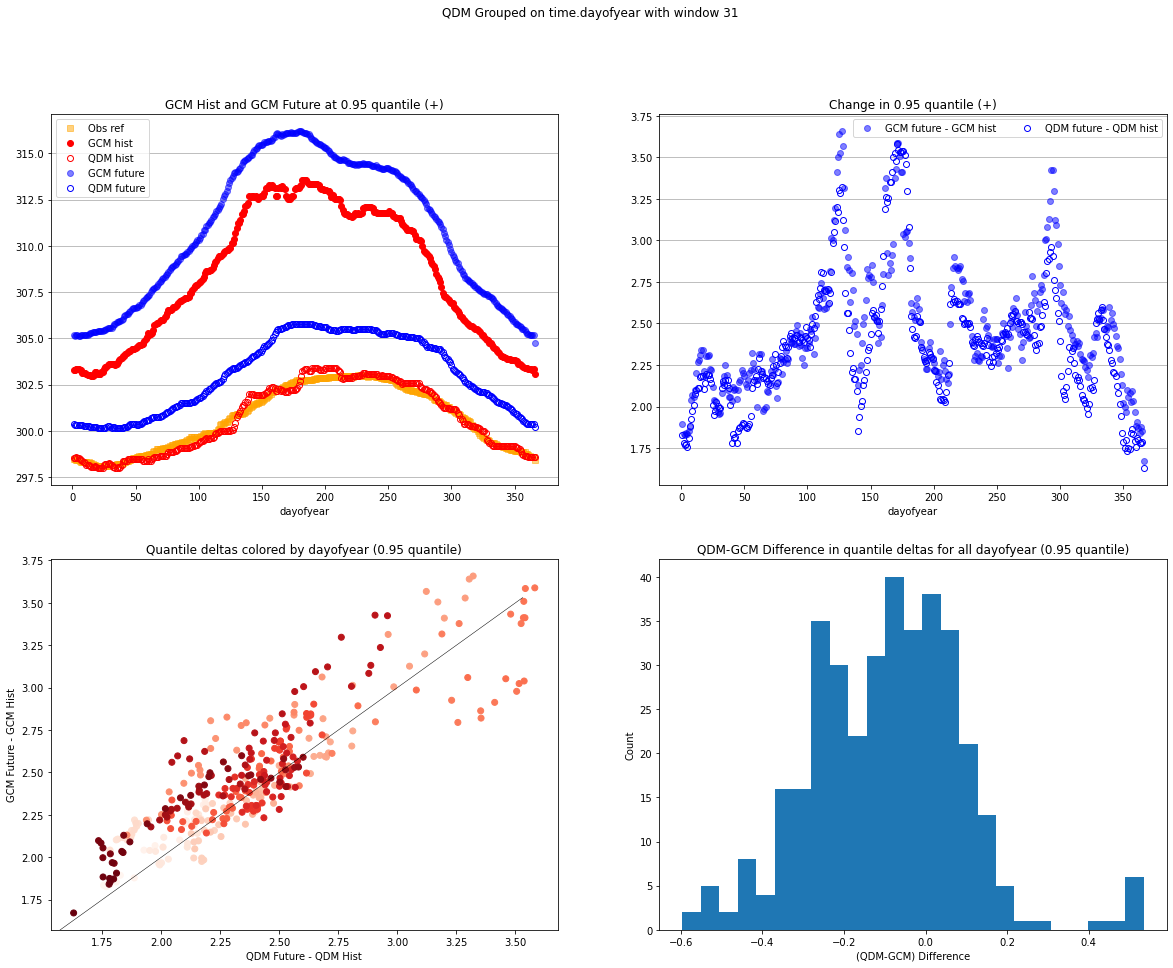

In [69]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

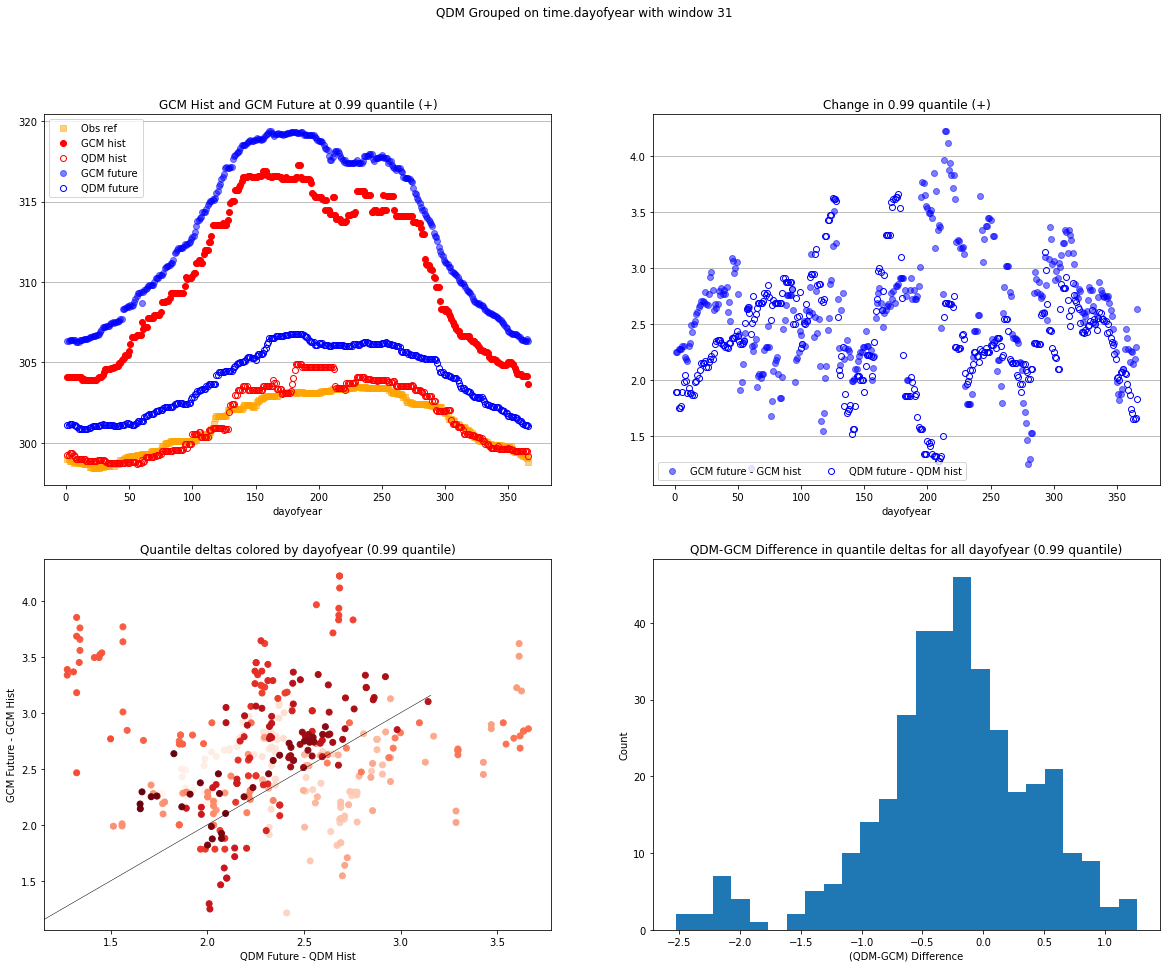

In [70]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

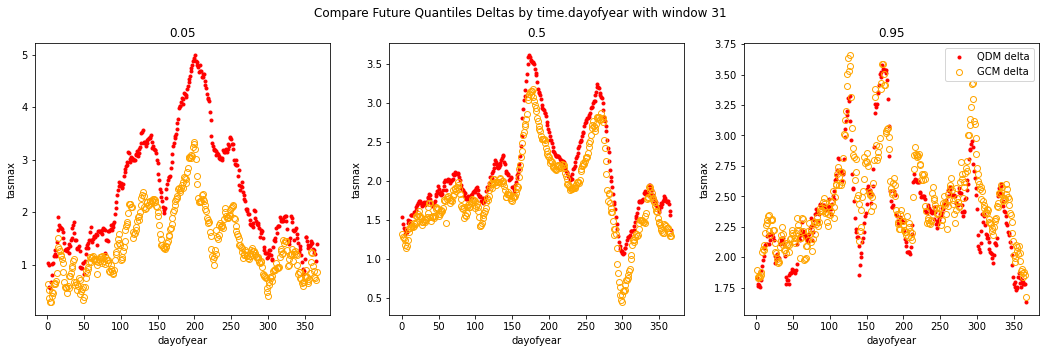

In [71]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

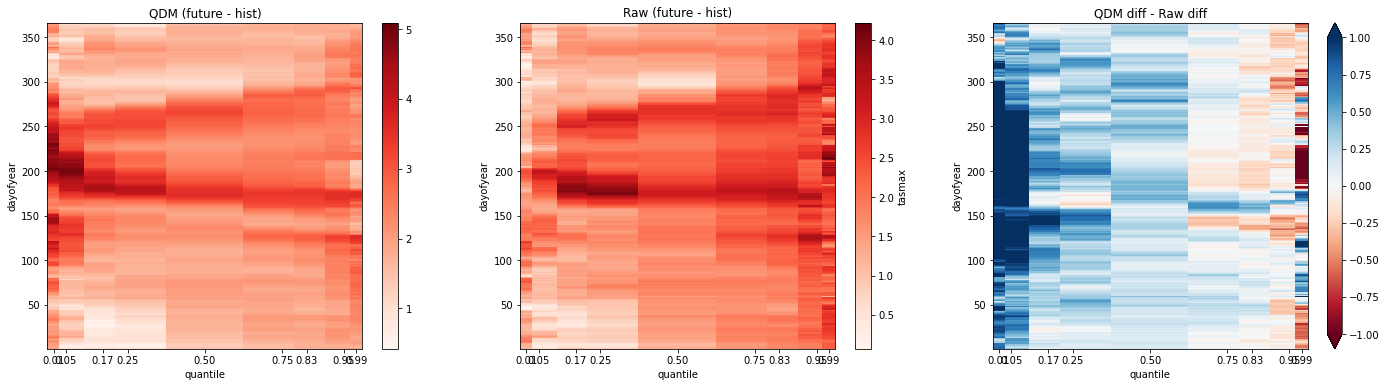

In [72]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.01,.05,.17,.25,.5,.75,.83,.95,.99])

Quantile number = 600

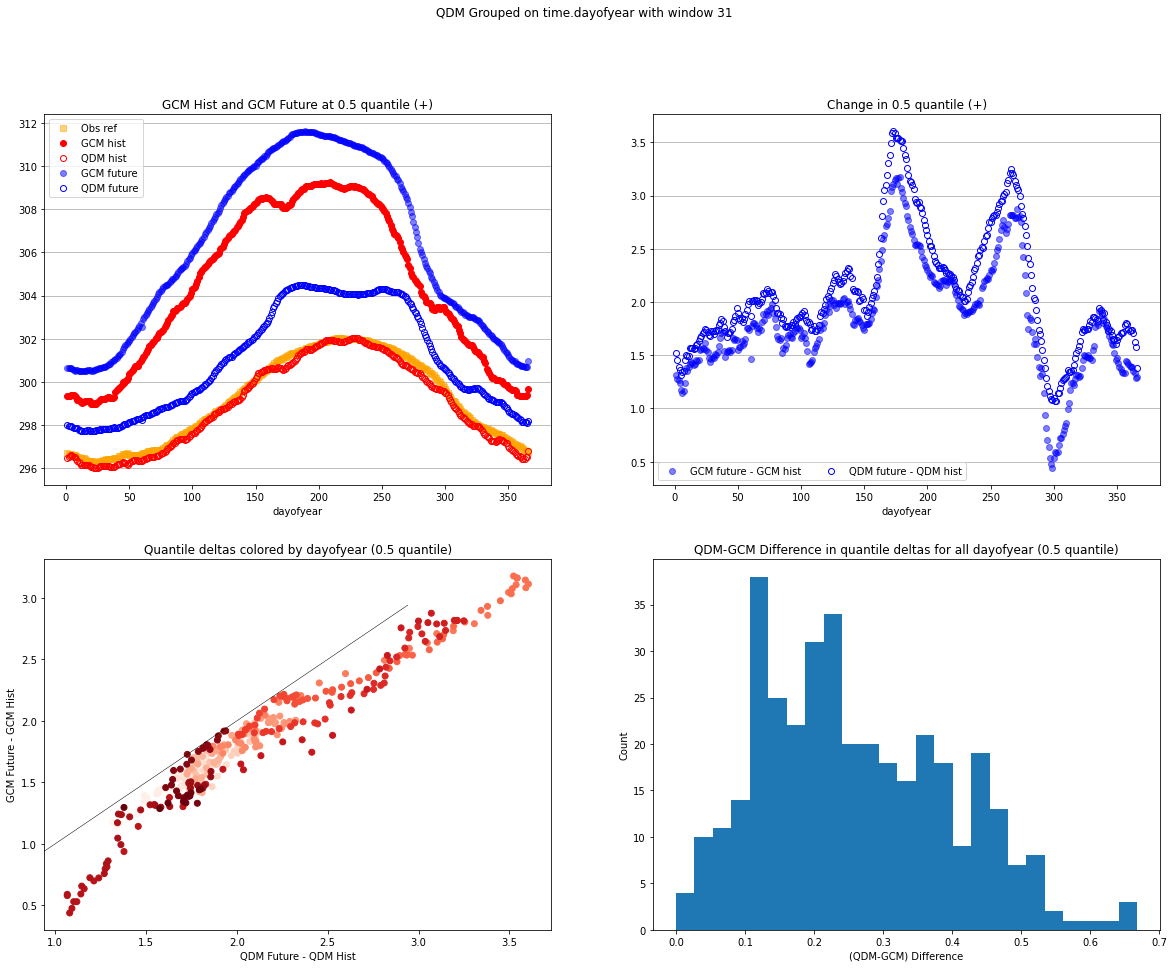

In [81]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

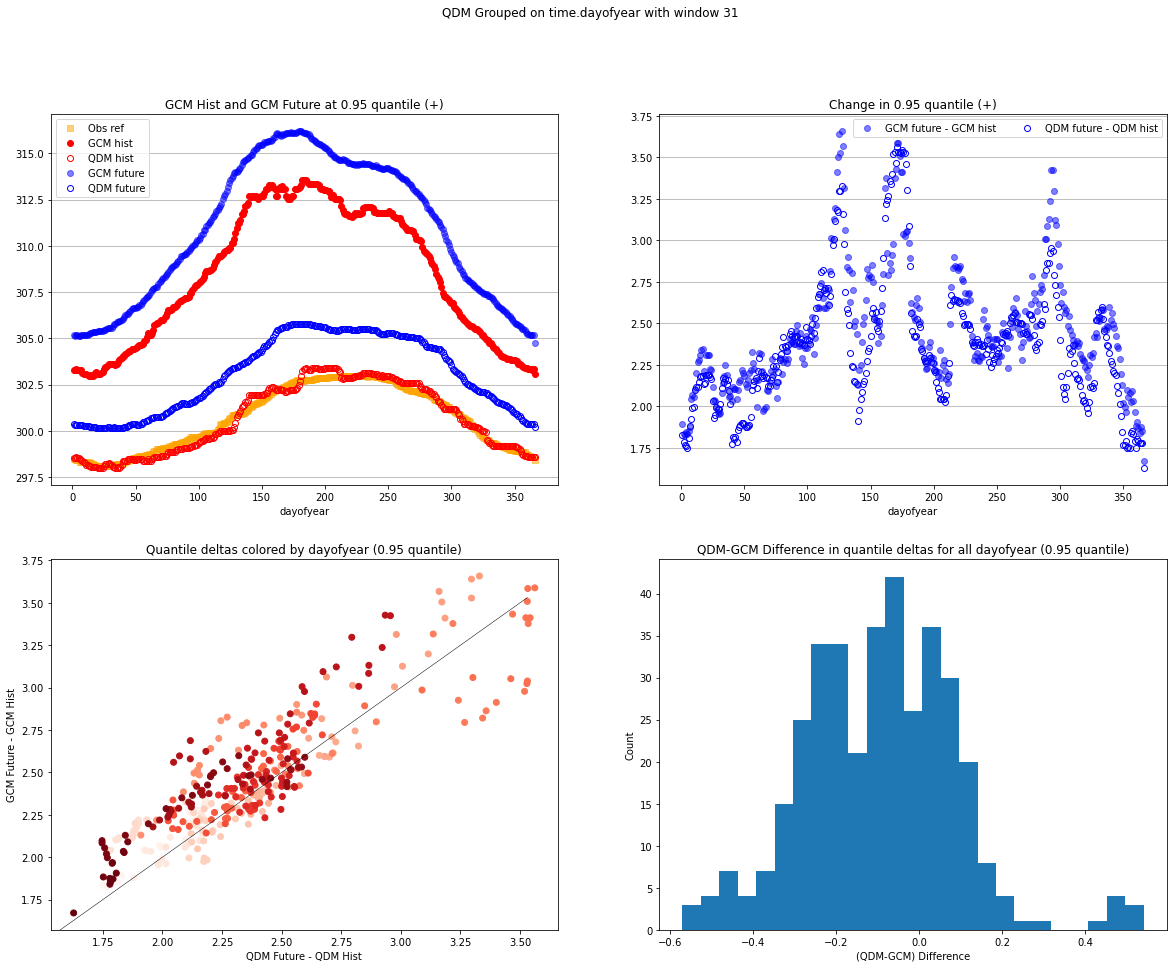

In [82]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

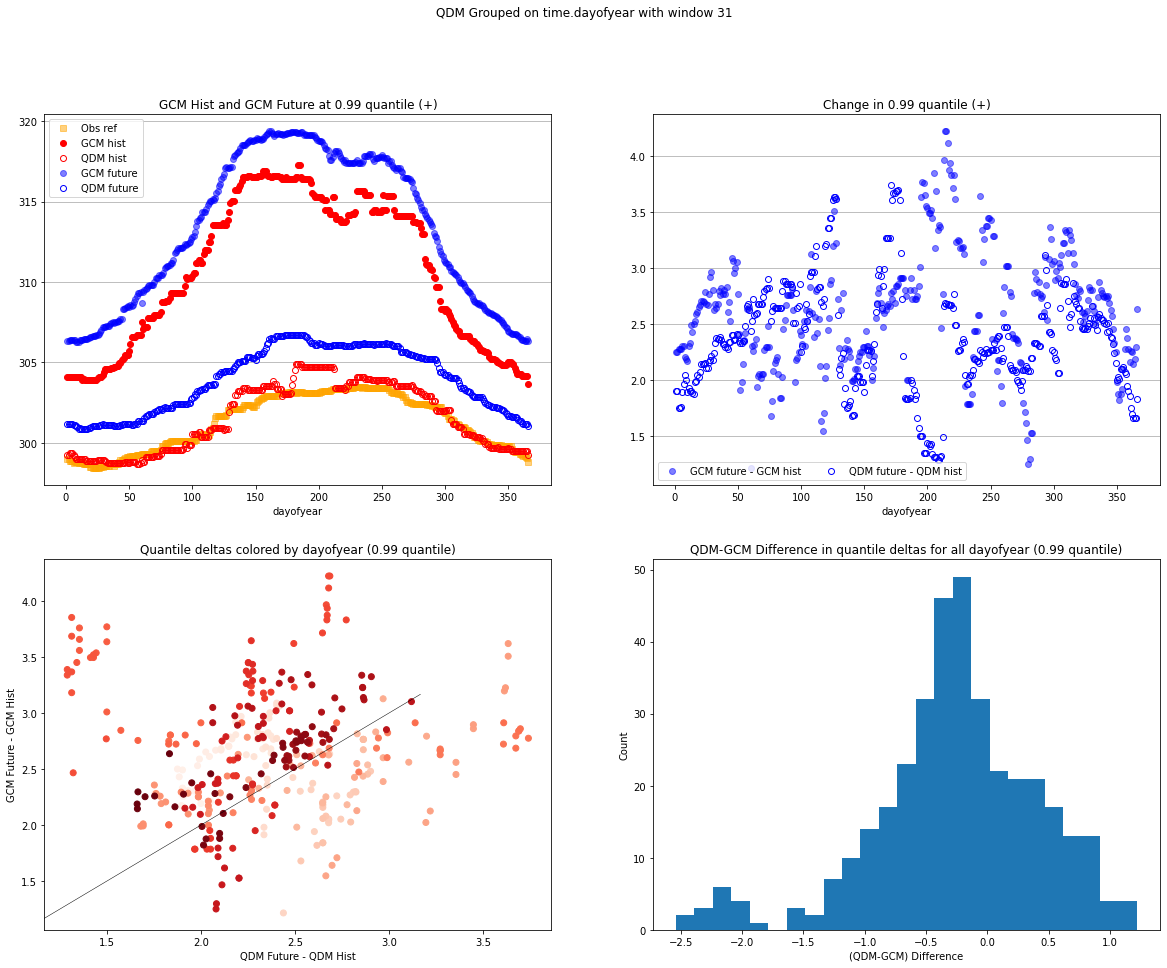

In [83]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

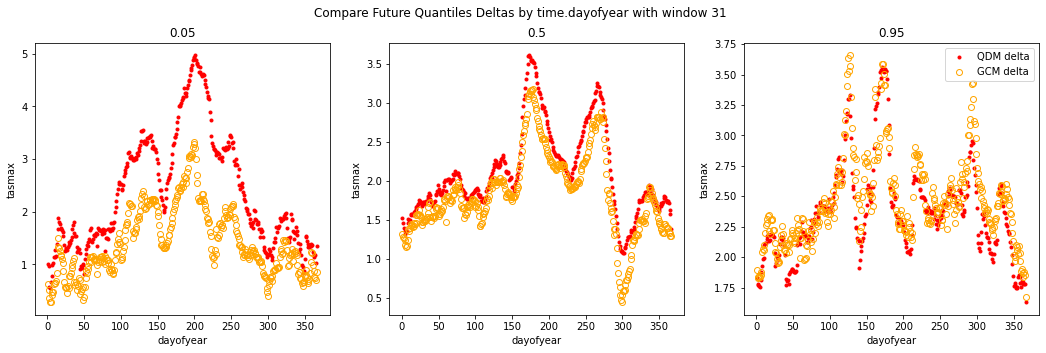

In [84]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

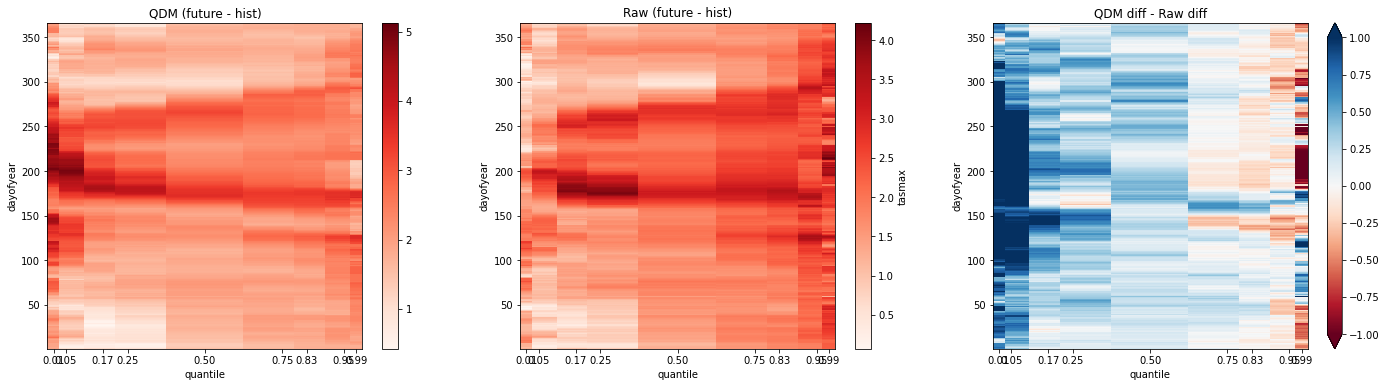

In [85]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.01,.05,.17,.25,.5,.75,.83,.95,.99])

Quantile number = 50

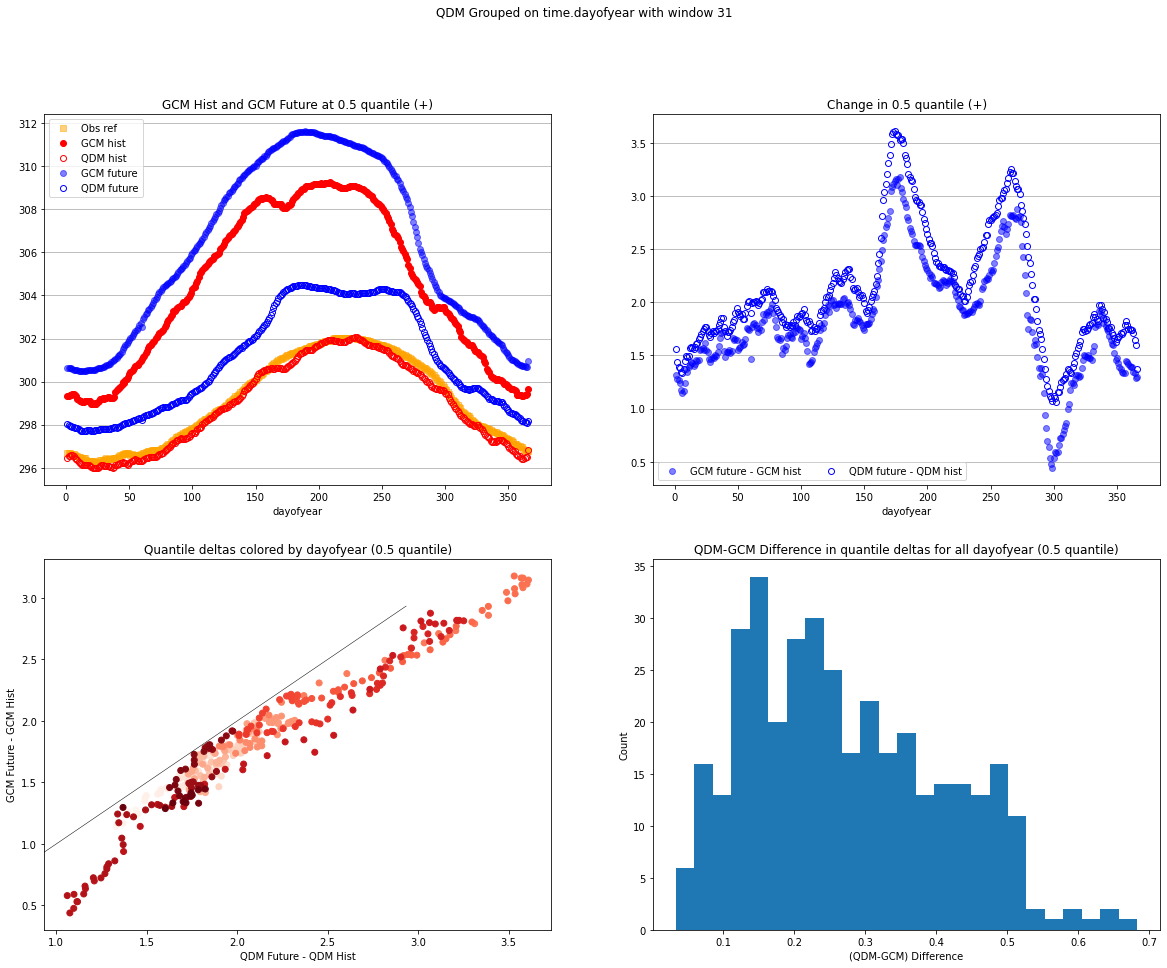

In [94]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

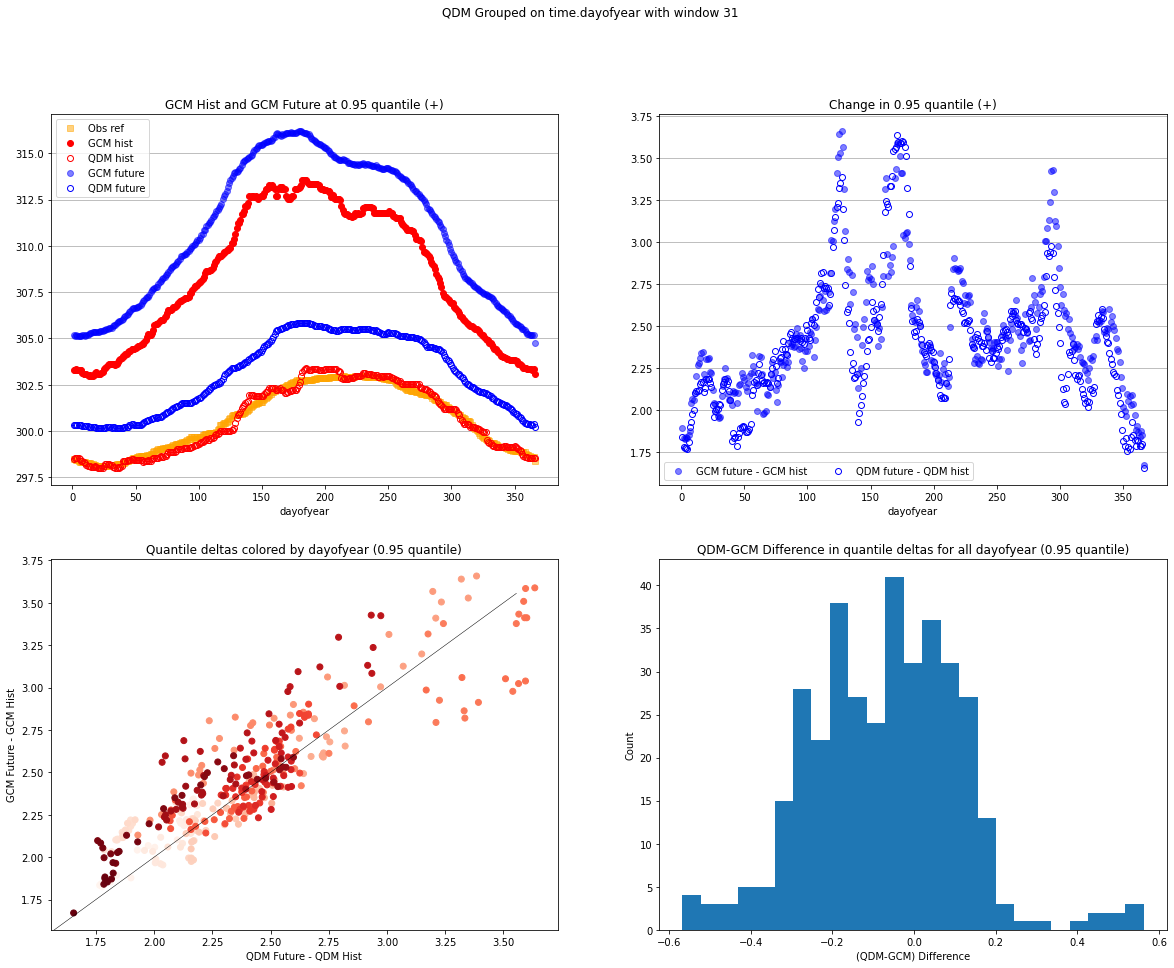

In [95]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

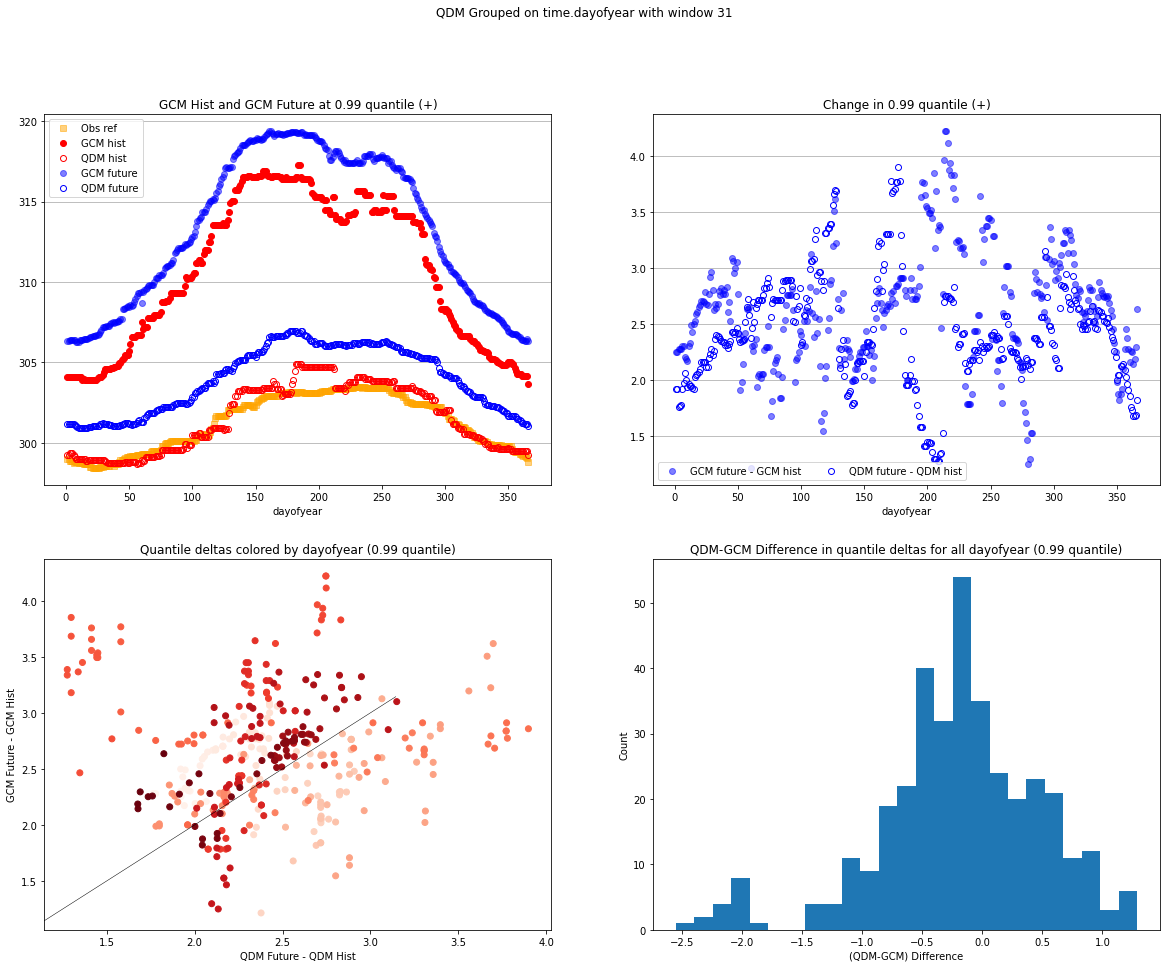

In [96]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

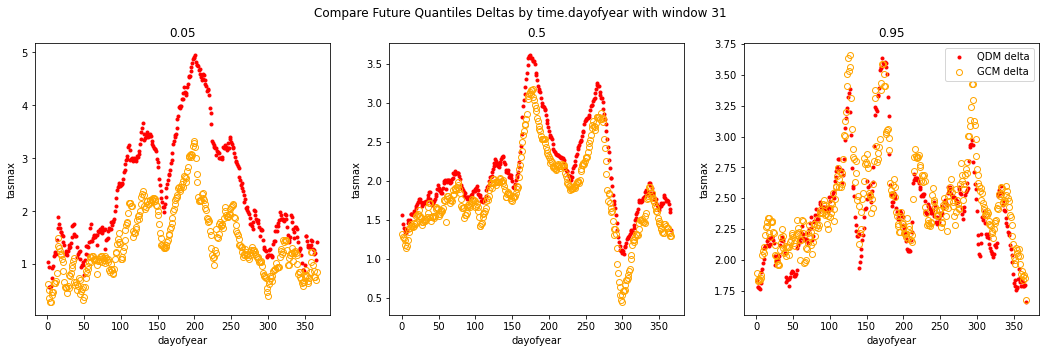

In [97]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

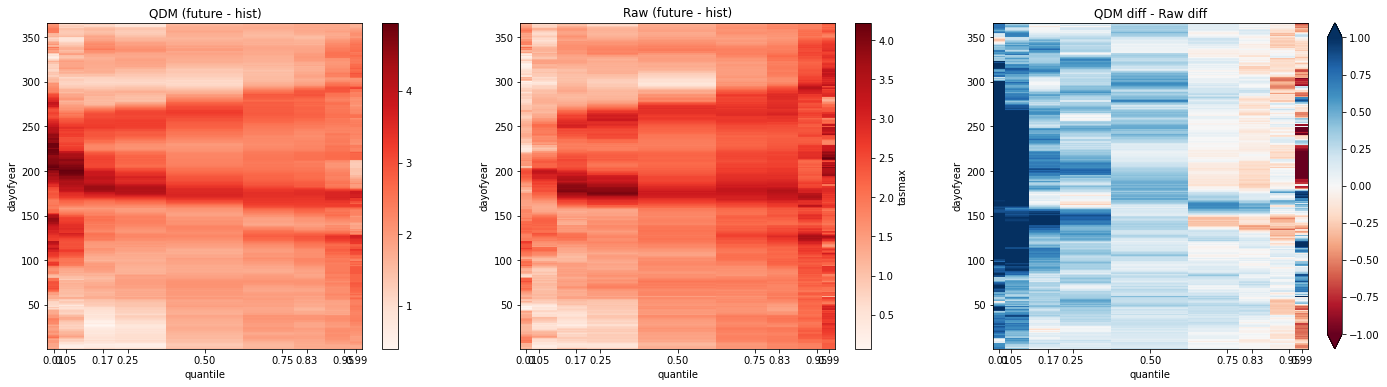

In [98]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.01,.05,.17,.25,.5,.75,.83,.95,.99])

Quantile number = 25

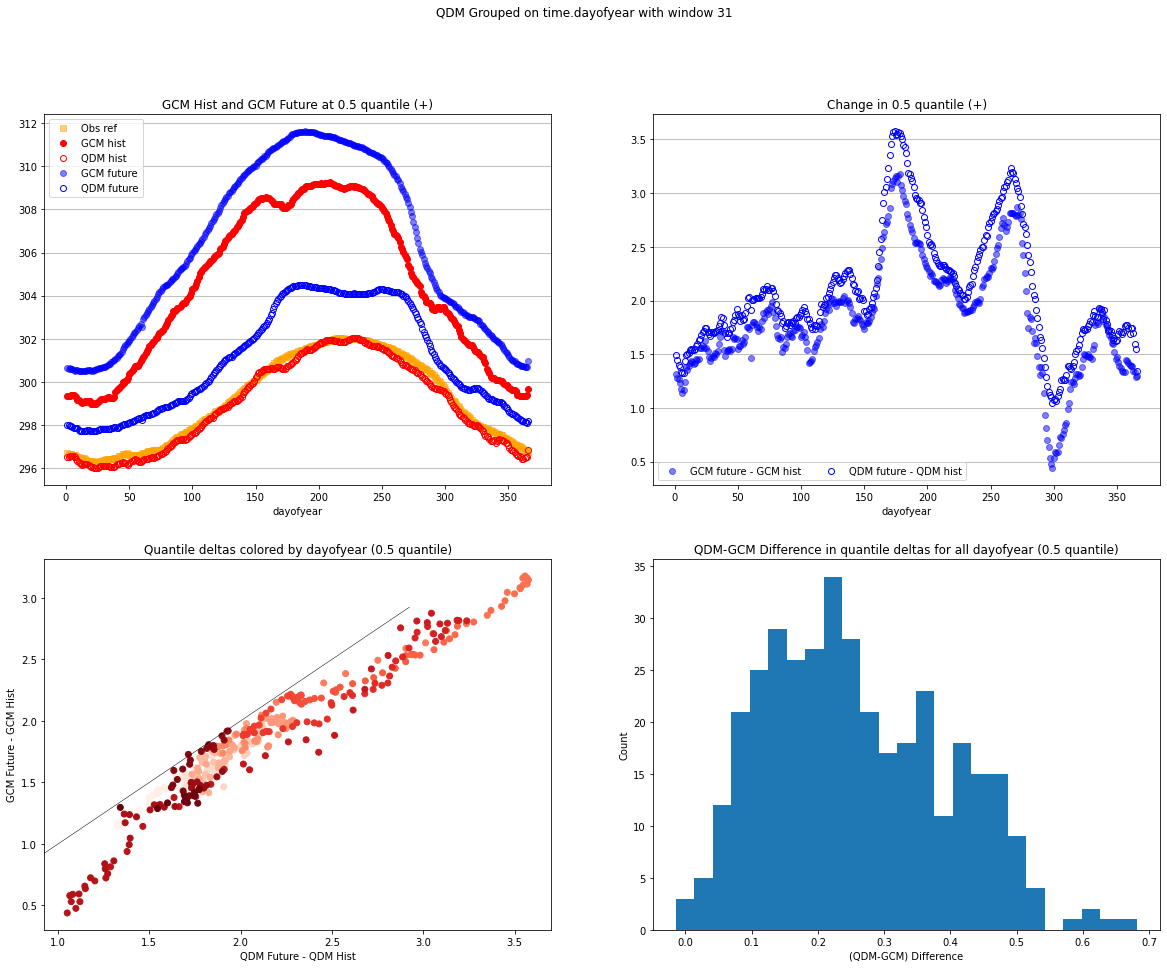

In [107]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.5], simple=True, tworow=True)

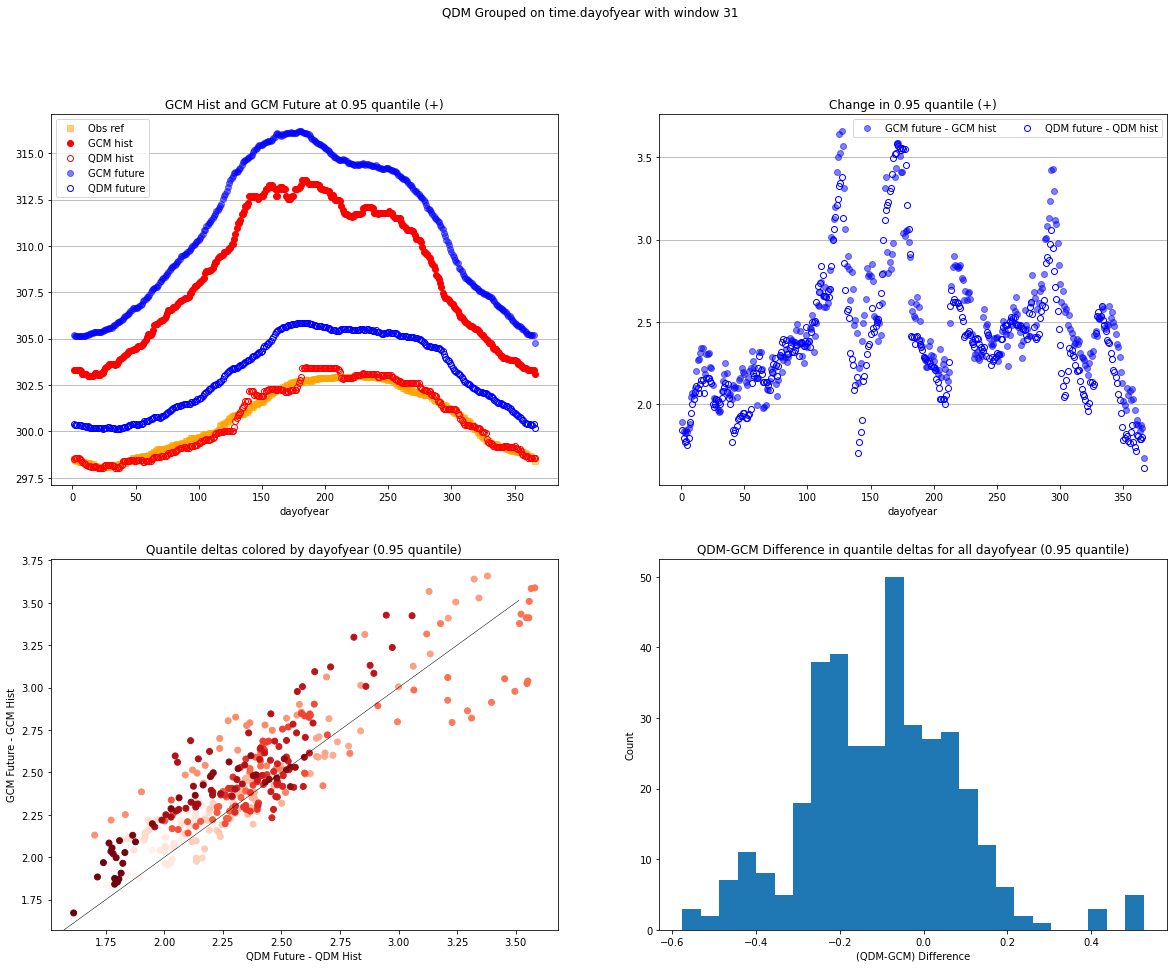

In [108]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.95], simple=True, tworow=True)

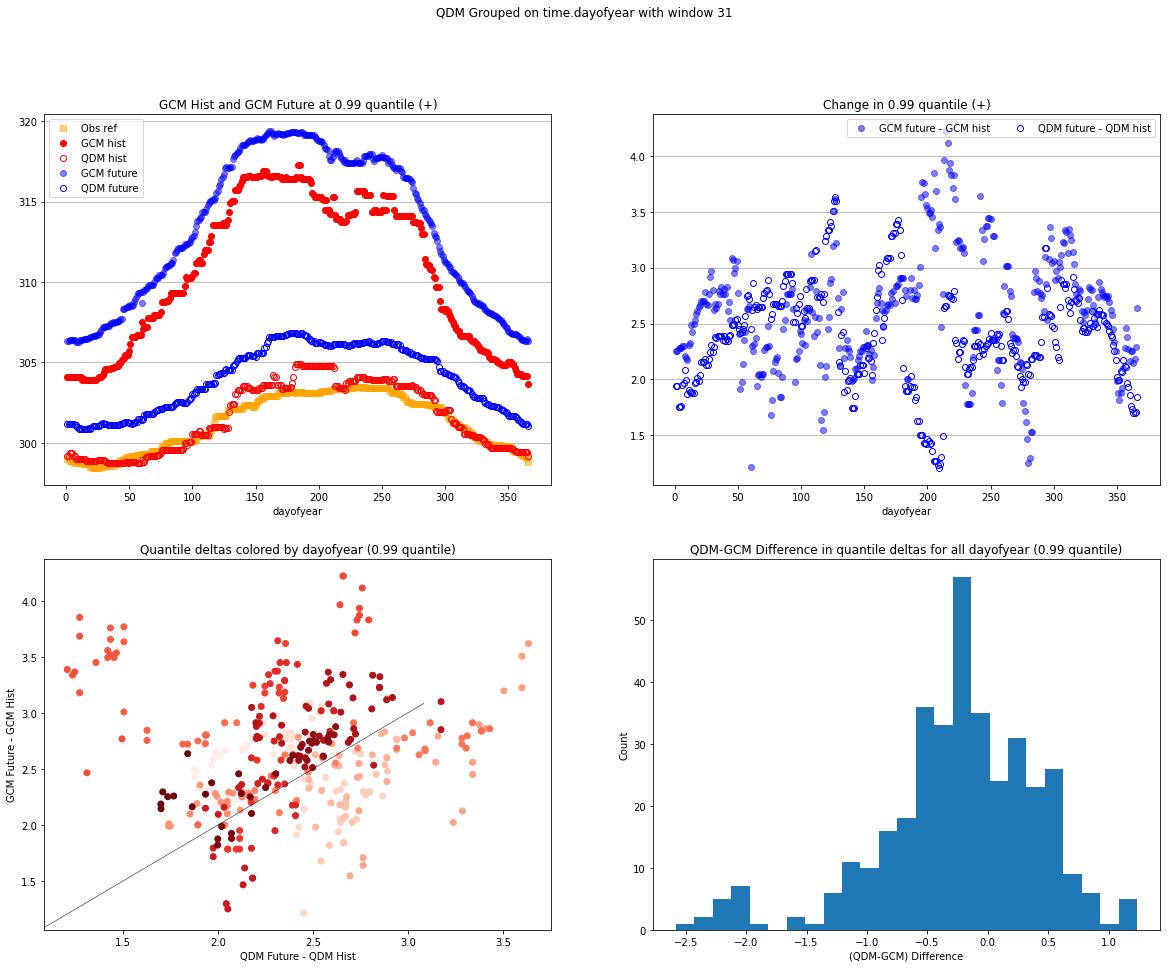

In [109]:
_ = quantile_compare_plot(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.99], simple=True, tworow=True)

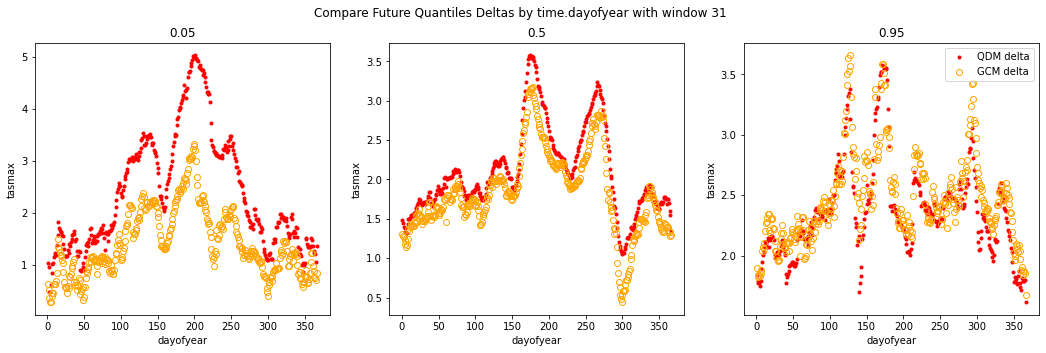

In [110]:
_ = compare_gcm_qdm_quantile_deltas(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper)

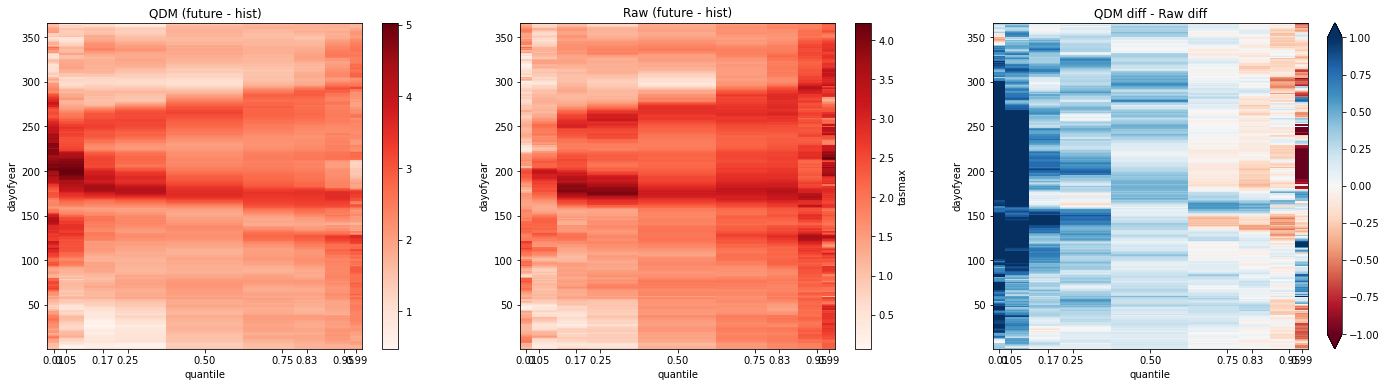

In [111]:
_ = plot_quantile_delta_differences_by_group(raw_dict, adjusted_dict, kind=kind, grouper=bcgrouper, quantiles=[.01,.05,.17,.25,.5,.75,.83,.95,.99])

In [64]:
# Calculating the means across time
sim

<xarray.DataArray 'tasmax' (time: 31390)>
array([269.31406, 274.50302, 274.6317 , ..., 285.3978 , 283.96222,
       286.47925], dtype=float32)
Coordinates:
    lat        float64 40.0
    lon        float64 260.6
  * time       (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-11-15T10:38:50Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

In [65]:
def group_calculate_trend(da):
    '''
    create function to create groups, loop through each day of grouping, calculate and save the trend (z,p)
    '''
    #pass da, create groups
    groups = da.groupby('dayofyear').groups
    
    z_dayofyear = []
    p_dayofyear = []

    # loop through dict groups for indices corresponding to each dayofyear
    for days in range(1,len(groups)+1):
        indices = groups[days]

        all_dates = []
        # loop through each index for all dayofyear instances 
        for date in range(0,len(indices)):
            da_alldates = da[indices[date]]
            all_dates.append(da_alldates)

        # turn list into DataArray -- becomes the array over which to calculate the trend
        all_dates = xr.DataArray(all_dates)

        # calculate trends in time across day of year
        years = np.unique(da.time.dt.year)
        
        # calc the trend of each day across years
        z = np.polyfit(years, all_dates, 1)
        p = np.poly1d(z)
        
        #print(z)
        #print(p)
        z_dayofyear.append(z)
        p_dayofyear.append(p)
        
    return [z_dayofyear, p_dayofyear]

In [66]:
[z_ref,p_ref] = group_calculate_trend(ref)

In [67]:
[z_hist,p_hist] = group_calculate_trend(hist)

In [68]:
[z_hist_qdm,p_hist_qdm] = group_calculate_trend(hist_qdm)

In [69]:
[z_sim,p_sim] = group_calculate_trend(sim)

In [70]:
[z_sim_qdm,p_sim_qdm] = group_calculate_trend(sim_qdm)

In [71]:
[z_sim_rqdm,p_sim_rqdm] = group_calculate_trend(simy_qdm)

In [80]:
days = np.arange(1,366)
len(days)

365

In [72]:
def transform_z_to_da(da):
    all_slopes = []
    
    for i_len in range(0,len(da)):

        z_values = da[i_len]
        all_slopes.append(z_values[0])
    
    all_slopes = xr.DataArray(all_slopes)
    return all_slopes

In [73]:
slopes_ref = transform_z_to_da(z_ref)

In [74]:
slopes_hist = transform_z_to_da(z_hist)

In [75]:
slopes_hist_qdm = transform_z_to_da(z_hist_qdm)

In [76]:
slopes_sim = transform_z_to_da(z_sim)

In [77]:
slopes_sim_qdm = transform_z_to_da(z_sim_qdm)

In [78]:
slopes_sim_rqdm = transform_z_to_da(z_sim_rqdm)

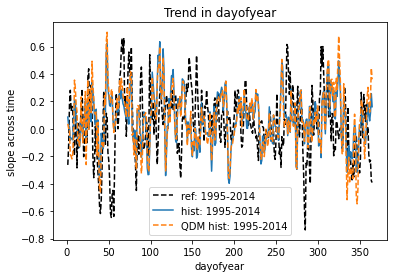

In [82]:
fig = plt.figure()
plt.plot(days, slopes_ref, "k--", label='ref: 1995-2014')
plt.plot(days, slopes_hist, label='hist: 1995-2014')
plt.plot(days, slopes_hist_qdm, linestyle='dashed', label='QDM hist: 1995-2014')

plt.title('Trend in dayofyear')
plt.xlabel('dayofyear')
plt.ylabel('slope across time')

plt.legend()

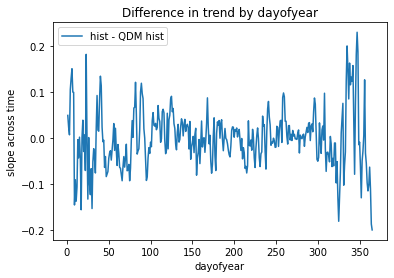

In [96]:
fig = plt.figure()

plt.plot(days, (slopes_hist - slopes_hist_qdm), label='hist - QDM hist')

plt.title('Difference in trend by dayofyear')
plt.xlabel('dayofyear')
plt.ylabel('slope across time')

plt.legend()

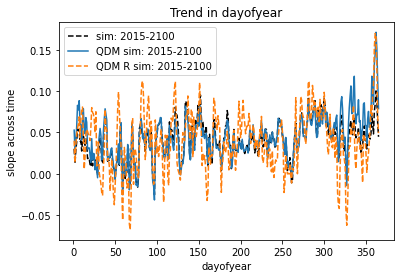

In [95]:
fig = plt.figure()

plt.plot(days, slopes_sim, "k--", label='sim: 2015-2100')
plt.plot(days, slopes_sim_qdm, label='QDM sim: 2015-2100')
plt.plot(days, slopes_sim_rqdm, linestyle='dashed', label='QDM R sim: 2015-2100')

plt.title('Trend in dayofyear')
plt.xlabel('dayofyear')
plt.ylabel('slope across time')

plt.legend()

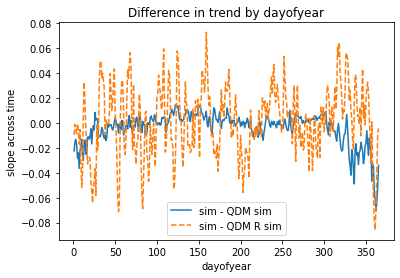

In [97]:
fig = plt.figure()

plt.plot(days, (slopes_sim - slopes_sim_qdm), label='sim - QDM sim')
plt.plot(days, (slopes_sim - slopes_sim_rqdm), linestyle='dashed', label='sim - QDM R sim')

plt.title('Difference in trend by dayofyear')
plt.xlabel('dayofyear')
plt.ylabel('slope across time')

plt.legend()

In [170]:
slopes2_ref = transform_z_to_da(p_ref)

In [171]:
slopes2_hist = transform_z_to_da(p_hist)

In [172]:
slopes2_sim = transform_z_to_da(p_sim)

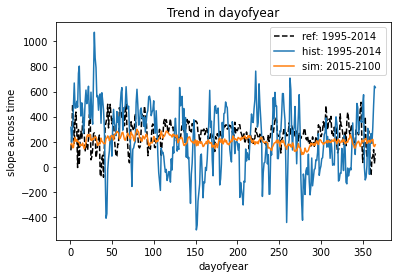

In [173]:
fig = plt.figure()
plt.plot(days, slopes2_ref, "k--", label='ref: 1995-2014')
plt.plot(days, slopes2_hist, label='hist: 1995-2014')
plt.plot(days, slopes2_sim, label='sim: 2015-2100')

plt.title('Trend in dayofyear')
plt.xlabel('dayofyear')
plt.ylabel('slope across time')

plt.legend()

In [174]:
p_ref

[poly1d([8.26114511e-02, 1.31209783e+02]),
 poly1d([2.35506904e-02, 2.49536658e+02]),
 poly1d([-1.00183151e-01,  4.97111313e+02]),
 poly1d([-5.48689304e-02,  4.05339274e+02]),
 poly1d([5.40048011e-02, 1.86926342e+02]),
 poly1d([-3.51810082e-02,  3.66521449e+02]),
 poly1d([-7.00681070e-02,  4.36450954e+02]),
 poly1d([-2.16640386e-03,  3.00183150e+02]),
 poly1d([ 0.15047995, -5.87238639]),
 poly1d([-8.57085034e-04,  2.97308586e+02]),
 poly1d([ 0.13952726, 16.01223057]),
 poly1d([3.30027645e-02, 2.29971831e+02]),
 poly1d([6.39276720e-03, 2.83167208e+02]),
 poly1d([3.66475270e-02, 2.22779778e+02]),
 poly1d([-3.16777509e-02,  3.58960054e+02]),
 poly1d([-4.73704173e-02,  3.90578414e+02]),
 poly1d([2.02390972e-02, 2.55122211e+02]),
 poly1d([8.82708327e-02, 1.18576045e+02]),
 poly1d([5.28381577e-02, 1.89607457e+02]),
 poly1d([6.00133222e-02, 1.75374885e+02]),
 poly1d([8.06003198e-02, 1.33907164e+02]),
 poly1d([3.60432331e-02, 2.23425076e+02]),
 poly1d([-5.97043833e-02,  4.15449884e+02]),
 poly